In [1]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer, silhouette_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import Normalizer
from scipy.cluster.hierarchy import linkage, dendrogram
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

MCS - BeNeFri
Social Media Analytics, Fall 2020
Project - Data Mining meets Recommender Systems
@authors: Guillaume Chacun, Fabien Vorpe

# Clustering

## Load user profiles

In [2]:
user_profiles_filename = 'user_profiles_hospitality_dataset_2020.csv'
users_cluster_filename = 'users_cluster_hospitality_dataset_2020.csv'

In [3]:
# read data
raw_data = pd.read_csv(f'./data/{user_profiles_filename}')
user_ids = raw_data['user_id']
del raw_data['user_id']
raw_data.head()

9731_read  9731_likes  9731_posts  9731_comments  7174_read  7174_likes  \
0          0           0           0              0          0           0   
1          0           0           0              0          0           0   
2          0           0           0              0          0           0   
3          0           0           0              0          0           0   
4          0           0           0              0          0           0   

   7174_posts  7174_comments  12807_read  12807_likes  ...  132077_posts  \
0           0              0           0            0  ...             0   
1           0              0           0            0  ...             0   
2           0              0           0            0  ...             0   
3           0              0           0            0  ...             0   
4           0              0           0            0  ...             0   

   132077_comments  132078_read  132078_likes  132078_posts  132078_comments  \
0                0            0             0             0                0   
1                0            0             0             0                0   
2                0            0             0             0                0   
3                0            0             0             0                0   
4                0            0             0             0                0   

   50683_read  50683_likes  50683_posts  50683_comments  
0           0            0            0               0  
1           0            0            0               0  
2           0            0            0               0  
3           0            0            0               0  
4           0            0            0               0  

[5 rows x 516 columns]

## Main pipeline

### Data pre-processing

In [4]:
raw_data.shape

(7767, 516)

In [5]:
# remove columns where sum of interactions are lower than a threshold
MIN_N_INTERACTIONS = 6
data = raw_data[raw_data.columns[raw_data.sum()>=MIN_N_INTERACTIONS]]
data.shape

(7767, 263)

In [8]:
# count number of removed columns per feature
rmvd_columns = [column.split('_')[1] for column in raw_data[raw_data.columns[raw_data.sum()<MIN_N_INTERACTIONS]].columns]
nb_rmvd_features = {}
for rmvd_col in rmvd_columns:
    try:
        nb_rmvd_features[rmvd_col] += 1
    except:
        nb_rmvd_features[rmvd_col] = 1
print(f'Number of removed columns per feature: {nb_rmvd_features}')

Number of removed columns per feature: {'likes': 56, 'posts': 76, 'comments': 80, 'read': 41}


### Grid Search - parameters space research

In [6]:
# params grids
params_grid = {
    'normalization__norm': ['l1', 'l2'],
    'dim_reduction__n_components': range(data.shape[1], int(data.shape[1] / 3), -40),
    'clustering__n_clusters': range(25, 60, 5), # 129 streams
}

kmeans_unique_params_grid = {
    
}

spectral_clustering_unique_params_grid = {
    'clustering__affinity': ['nearest_neighbors', 'rbf'],
    'clustering__assign_labels': ['kmeans', 'discretize'],
    'clustering__n_jobs': [-1],
}

In [7]:
# custom scorer methods
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    X_transformed = estimator[:-1].fit_transform(X)
    return silhouette_score(X_transformed, labels)
def chs_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    X_transformed = estimator[:-1].fit_transform(X)
    return calinski_harabasz_score(X_transformed, labels)

In [8]:
scaler = 1 # minmax: 0, maxabs: 1
classifier = 0 # kmeans: 0, spectral clustering: 1
scorer = 0 # silhouette score: 0, calinski harabasz score: 1

In [9]:
# pipelines
def create_pipelines(scaler, classifier, def_normalizers_params={}, def_scaler_params={}, def_pca_params={}, def_clf_params={}):
    preparation_pipe = Pipeline(steps=[
        ('normalization', Normalizer(**def_normalizers_params)), # normalization
        ('scaling', MinMaxScaler(**def_scaler_params) if scaler == 0 else MaxAbsScaler(**def_scaler_params)), # scaling
    ])
    clustering_pipe = Pipeline(steps = preparation_pipe.steps + [
        ('dim_reduction', PCA(**def_pca_params)), # dimensionality reduction
        ('clustering', KMeans(**def_clf_params) if classifier == 0 else SpectralClustering(**def_clf_params)), # clustering
    ])
    return preparation_pipe, clustering_pipe
preparation_pipe, clustering_pipe = create_pipelines(scaler, classifier)

In [ ]:
# init gridsearch
unique_clustering_params_grid = kmeans_unique_params_grid if classifier == 0 else spectral_clustering_unique_params_grid
all_params_grid = {**params_grid, **unique_clustering_params_grid}
custom_scorer = silhouette_scorer if scorer == 0 else chs_scorer

clf = GridSearchCV(clustering_pipe, all_params_grid, scoring=custom_scorer, cv=[(slice(None), slice(None))], n_jobs=(-1 if classifier == 0 else None))

In [ ]:
# run gridsearch
clf.fit(data)
print('best parameter {} '.format(clf.best_params_))

best parameter {'clustering__n_clusters': 55, 'dim_reduction__n_components': 103, 'normalization__norm': 'l2'} 


In [ ]:
clf.best_score_

0.6269361511882109

<table>
    <thead>
        <tr>
            <th>Metric</th>
            <th>Scaler</th>
            <th>Classifier</th>
            <th>Value</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=4>Silhouette score</td>
            <td rowspan=2>MinMaxScaler</td>
            <td>KMeans</td>
            <td>0.6090310813051844</td>
        </tr>
        <tr>
            <td>SpectralClustering</td>
            <td>0.6173662071162097</td>
        </tr>
        <tr>
            <td rowspan=2>MaxAbsScaler</td>
            <td>KMeans</td>
            <td><b>0.6269361511882109</b></td>
        </tr>
        <tr>
            <td>SpectralClustering</td>
            <td>0.6171898543758638</td>
        </tr>
        <tr>
            <td rowspan=4>Calinski-Harabasz score</td>
            <td rowspan=2>MinMaxScaler</td>
            <td>KMeans</td>
            <td>914.1717248370506</td>
        </tr>
        <tr>
            <td>SpectralClustering</td>
            <td>910.5382010121394</td>
        </tr>
        <tr>
            <td rowspan=2>MaxAbsScaler</td>
            <td>KMeans</td>
            <td><b>927.1104166083034</b></td>
        </tr>
        <tr>
            <td>SpectralClustering</td>
            <td>911.6142327160933</td>
        </tr>
    </tbody>
</table>

### Approaches comparison

In [10]:
kmeans_best_params = {'dim_reduction__n_components': 103, 'normalization__norm': 'l2'}
sc_best_params = {'clustering__n_jobs': -1, 'clustering__affinity': 'rbf', 'clustering__assign_labels': 'discretize', 'dim_reduction__n_components': 103, 'normalization__norm': 'l2'}
best_scaler = 1 # maxabs

In [11]:
def pipeline_steps_params(params):
    def_normalizers_params, def_scaler_params, def_pca_params, def_clf_params = {}, {}, {}, {}
    norm_keyword = 'normalization__'
    scaler_keyword = 'scaling__'
    pca_keyword = 'dim_reduction__'
    clf_keyword = 'clustering__'
    for key,value in params.items():
        if norm_keyword in key:
            def_normalizers_params[key.replace(norm_keyword, '')] = value
        elif scaler_keyword in key:
            def_scaler_params[key.replace(scaler_keyword, '')] = value
        elif pca_keyword in key:
            def_pca_params[key.replace(pca_keyword, '')] = value
        elif clf_keyword in key:
            def_clf_params[key.replace(clf_keyword, '')] = value
    return def_normalizers_params, def_scaler_params, def_pca_params, def_clf_params

In [12]:
# run gridsearch with only nb clustering varying for KMeans & SC with both scores
clusters_range = list(range(2,5,1)) + list(range(5, 70, 5))
scores = {}
for classifier in [0,1]:
    scores[classifier] = {'silhouette': [], 'chs': []}
    params = kmeans_best_params if classifier == 0 else sc_best_params
    
    preparation_pipe, clustering_pipe = create_pipelines(best_scaler, classifier, *pipeline_steps_params(params))
    n_clusters_param = {'clustering__n_clusters': clusters_range}
    
    for metric in ['silhouette', 'chs']:
        custom_scorer = silhouette_scorer if metric == 'silhouette' else chs_scorer
        clf = GridSearchCV(clustering_pipe, n_clusters_param, scoring=custom_scorer, cv=[(slice(None), slice(None))], n_jobs=(-1 if classifier == 0 else None))
        clf.fit(data)
        scores[classifier][metric] = clf.cv_results_['mean_test_score']

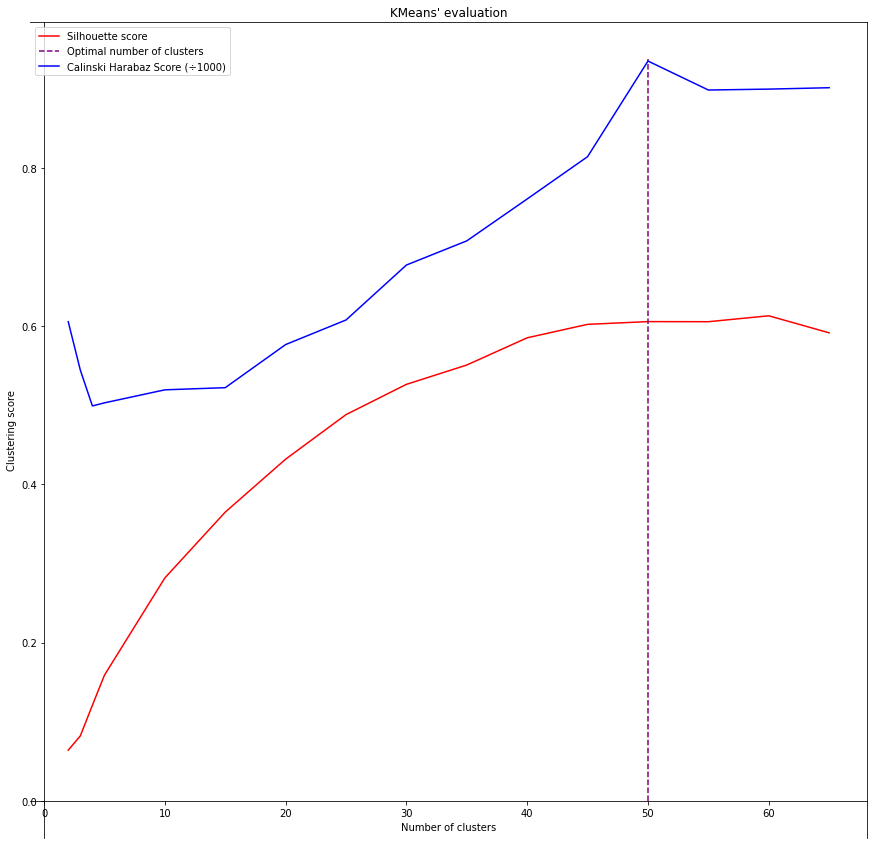

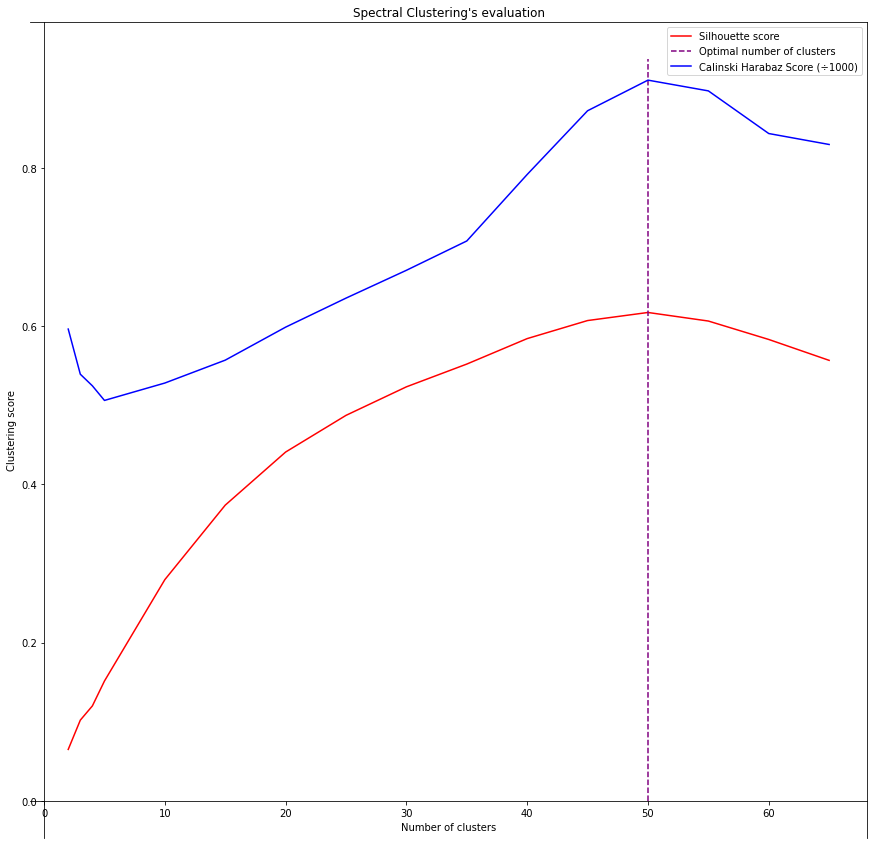

In [19]:
for classifier in [0,1]:
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title(("KMeans'" if classifier == 0 else "Spectral Clustering's") + " evaluation")
    ax.set_ylabel('Clustering score')
    ax.set_xlabel('Number of clusters')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.plot(clusters_range, scores[classifier]['silhouette'], 'r')
    x_maxima_sc = clusters_range[np.argmax(scores[classifier]['chs'], axis=0)]
    ax.plot([x_maxima_sc for _ in range(len(clusters_range))], list(np.arange(0, 1, 1/len(clusters_range))), '--', color='purple')
    ax.plot(clusters_range, [v/1000 for v in scores[classifier]['chs']], 'b')
    ax.legend(['Silhouette score', 'Optimal number of clusters', 'Calinski Harabaz Score (÷1000)'])

### Computing final clustering

In [20]:
best_nb_clusters = 50
best_classifier = 0
best_params = kmeans_best_params
best_params['clustering__n_clusters'] = best_nb_clusters

In [21]:
preparation_pipe, clustering_pipe = create_pipelines(best_scaler, best_classifier, *pipeline_steps_params(best_params))

In [22]:
cluster_labels = clustering_pipe.fit_predict(data)

In [29]:
# save user id - cluster id dataframe to csv
users_cluster = pd.DataFrame(zip(user_ids, cluster_labels), columns=['user_id', 'cluster_id'])
users_cluster.to_csv(f'./data/{users_cluster_filename}', header=True, index=False)
users_cluster.head()

user_id  cluster_id
0  80c79718-b5ae-4e79-9b1a-b42461b934d0           4
1  fee5578c-cbcd-402d-a698-db9a58af6fb2           8
2  284881a1-833d-49d9-9b7f-42094fdbbca1           8
3  be9ce283-a20f-4110-9523-e1c70d657add           4
4  0fe64dcb-547e-4f4f-a158-a66b5edd422f          29

### Clusters' properties

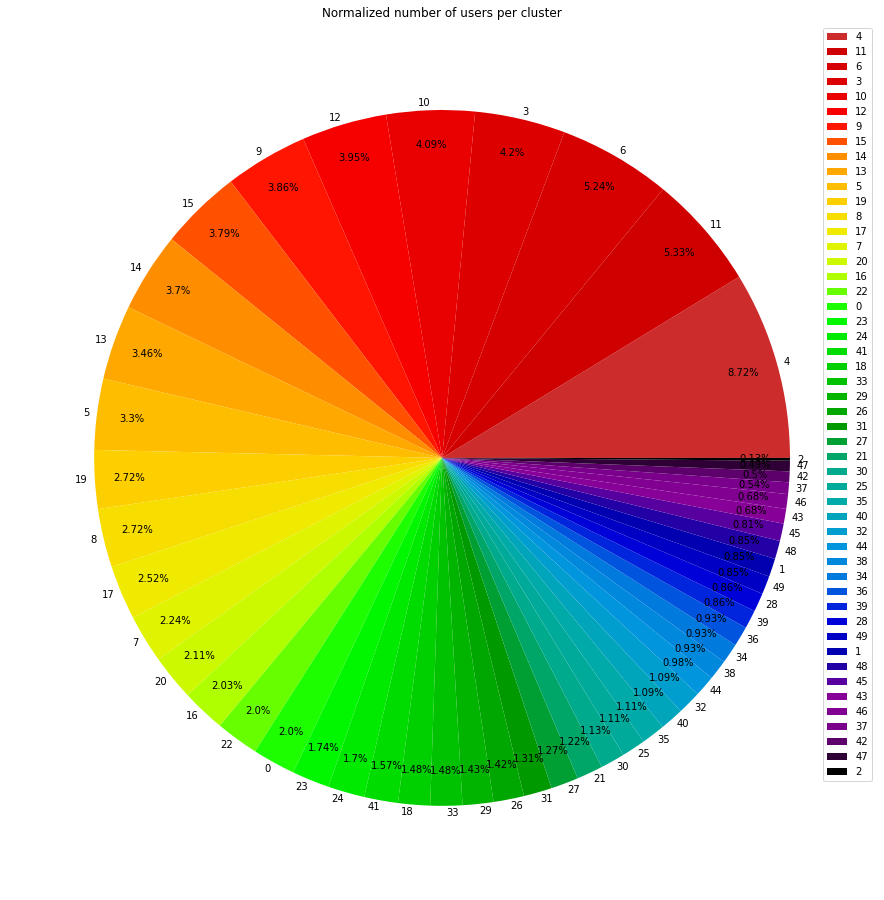

In [62]:
# pie plot for normalized number of users per cluster
plt.figure(figsize = (16, 16))
avg_nb_users_per_cluster = users_cluster['cluster_id'].value_counts(normalize=True)
cmap = plt.cm.nipy_spectral
plt.pie(avg_nb_users_per_cluster.values, 
        labels = avg_nb_users_per_cluster.index,
           colors=cmap(np.linspace(0.96, 0., len(avg_nb_users_per_cluster))),
           autopct=lambda x: str(round(x, 2)) + '%',
           pctdistance=0.9, labeldistance=1.02)
plt.title('Normalized number of users per cluster')
plt.legend()

In [68]:
# basic stats about the clusters
users_per_cluster_count = users_cluster['cluster_id'].value_counts(normalize=False).values
print('Average number of users per cluster:', users_per_cluster_count.mean())
print('Median of the number of users per cluster:', np.median(users_per_cluster_count))
print('Standard deviation of the number of users per cluster:', round(users_per_cluster_count.std(),2))
print('Minimum number of users per cluster:', users_per_cluster_count.min())
print('Maximum number of users per cluster:', users_per_cluster_count.max())

Average number of users per cluster: 155.34
Median of the number of users per cluster: 110.5
Standard deviation number of users per cluster: 124.12
Minimum number of users per cluster: 10
Maximum number of users per cluster: 677


In [ ]:
# for plots and stats: use default data (with only normalization & scaling applied)
transformed = preparation_pipe.fit_transform(raw_data)
labelled_data = pd.DataFrame(transformed, columns=raw_data.columns)
raw_columns = labelled_data.columns
labelled_data['label'] = cluster_labels

In [ ]:
stats = ['mean', 'std', 'min', 'max']
main_feature = 'read'
y_values = {}

# restructure the dataset
for cluster_id in set(cluster_labels): # for each cluster
    y_values[cluster_id] = {}
    users_in_cluster = labelled_data[labelled_data['label'] == cluster_id] # get users from cluster = cluster_id
    for raw_col_name in raw_columns: # for each column in the dataframe
        feature = raw_col_name.split('_')[1] # find which feature this column "represents"
        for stat in stats: # for each stat to compute
            # compute the stat for the users of this cluster and the selected column
            if stat == 'mean':
                value = users_in_cluster[raw_col_name].mean()
            elif stat == 'std':
                value = users_in_cluster[raw_col_name].std()
            elif stat == 'min':
                value = users_in_cluster[raw_col_name].min()
            elif stat == 'max':
                value = users_in_cluster[raw_col_name].max()

            # add the stat to the dictionary
            if feature not in y_values[cluster_id].keys():
                y_values[cluster_id][feature] = {}
            if stat not in y_values[cluster_id][feature].keys():
                y_values[cluster_id][feature][stat] = []
            y_values[cluster_id][feature][stat].append(value)

In [ ]:
stream_names, features = [set(var) for var in zip(*[col_name.split('_') for col_name in raw_data.columns])]
features.remove(main_feature)
features = [main_feature] + sorted(features) # sort features by name with first one being the "main feature"

### Clusters visualization

#### Radars

Source:
https://matplotlib.org/3.1.1/gallery/specialty_plots/radar_chart.html

In [ ]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, theta, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            return Circle((0.5, 0.5), 0.5)

        def _gen_axes_spines(self):
            return super()._gen_axes_spines()

    register_projection(RadarAxes)
    return theta

  0%|                                                                     | 0/50 [00:00<?, ?it/s]

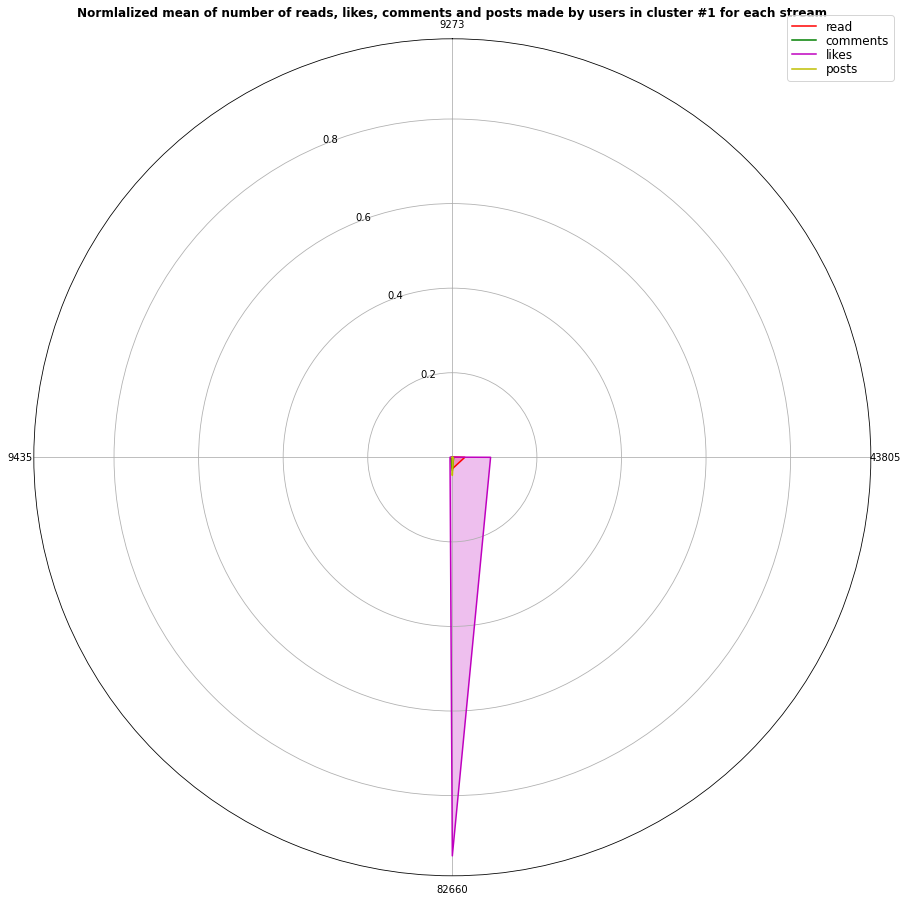

  2%|█▏                                                           | 1/50 [00:00<00:21,  2.30it/s]

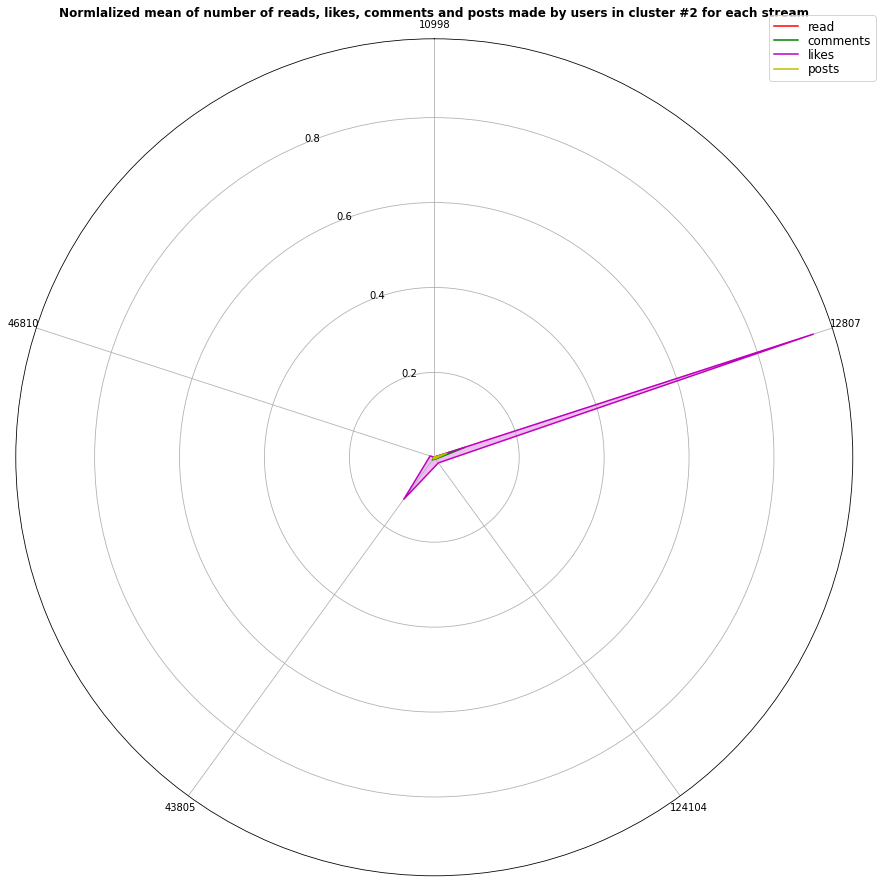

  4%|██▍                                                          | 2/50 [00:00<00:21,  2.28it/s]

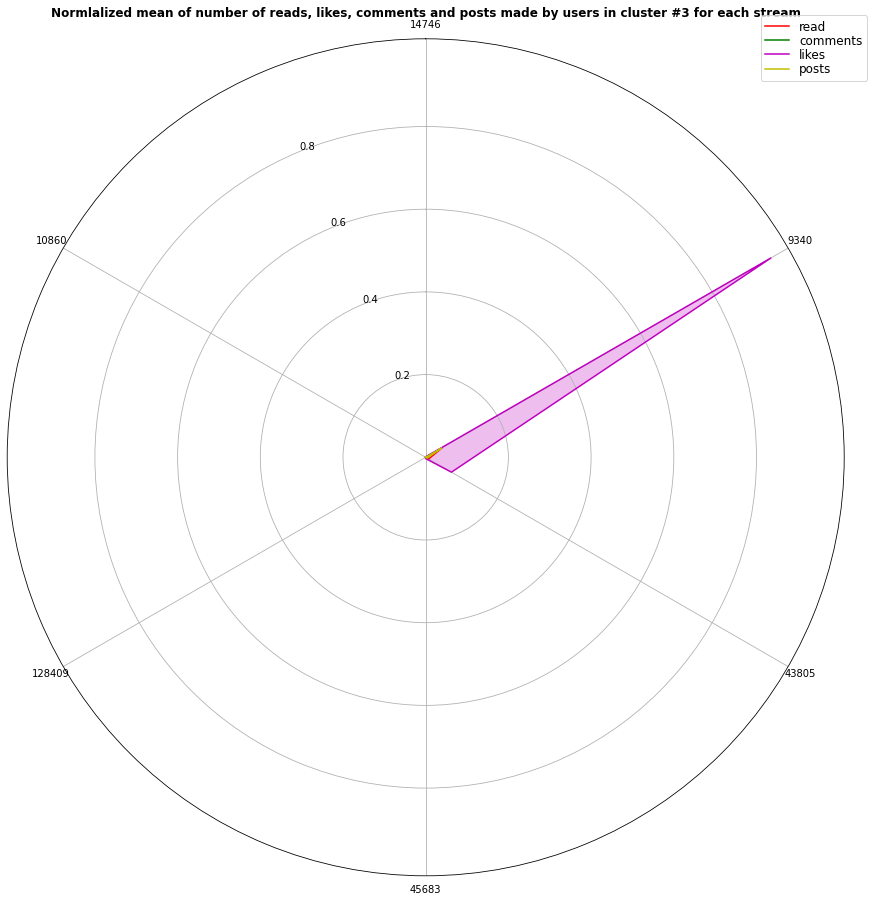

  6%|███▋                                                         | 3/50 [00:01<00:21,  2.23it/s]

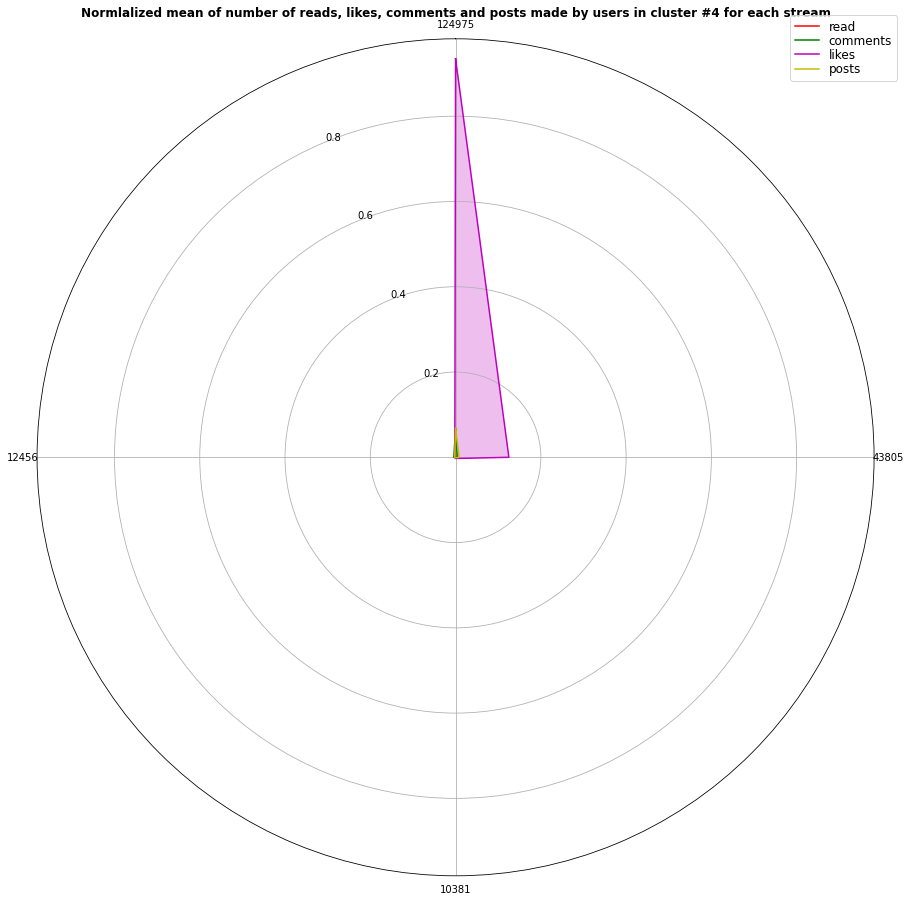

  8%|████▉                                                        | 4/50 [00:01<00:20,  2.25it/s]

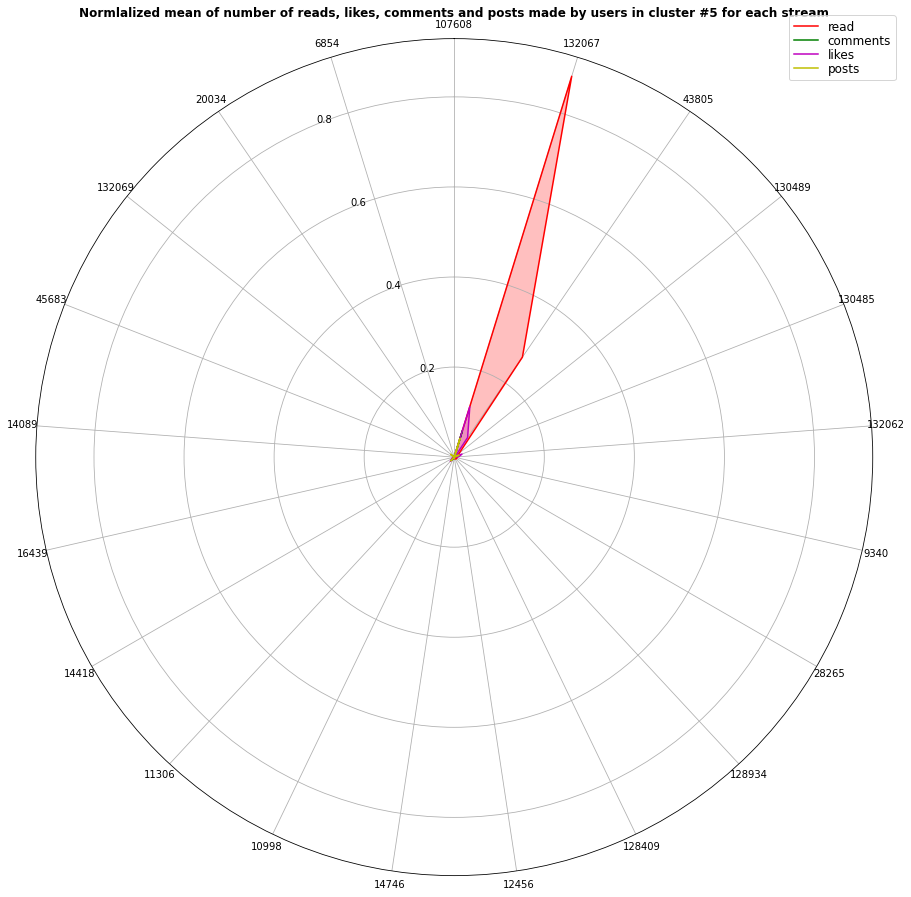

 10%|██████                                                       | 5/50 [00:02<00:24,  1.87it/s]

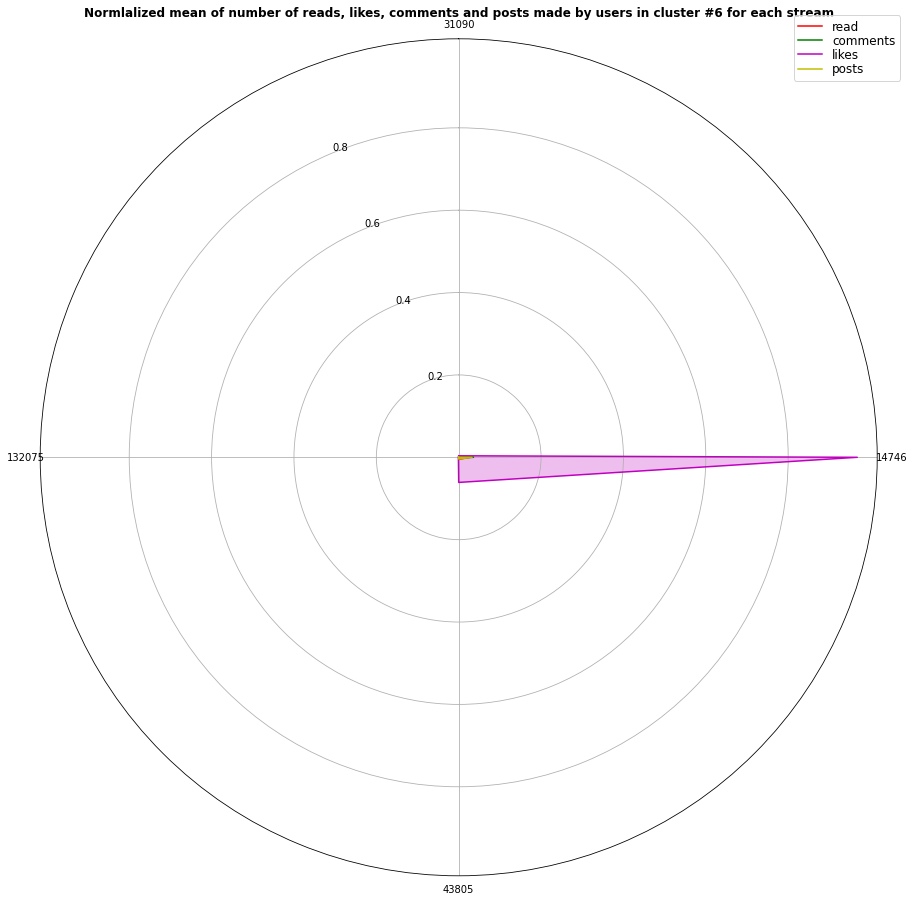

 12%|███████▎                                                     | 6/50 [00:02<00:22,  1.98it/s]

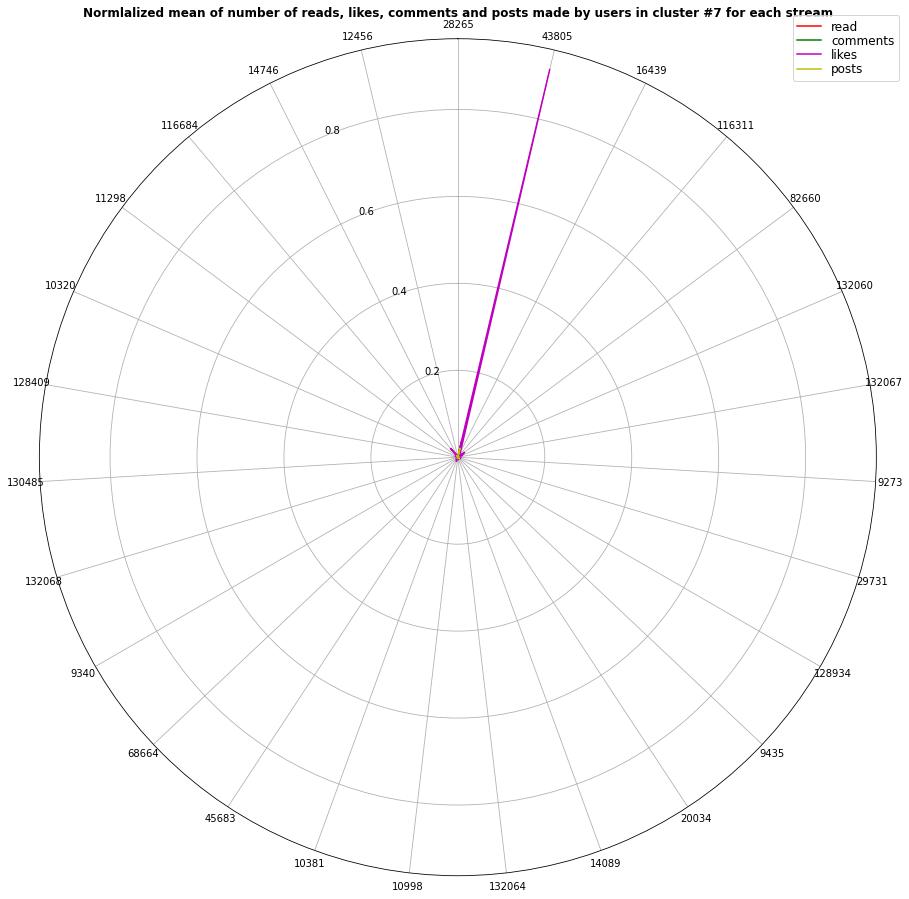

 14%|████████▌                                                    | 7/50 [00:03<00:25,  1.66it/s]

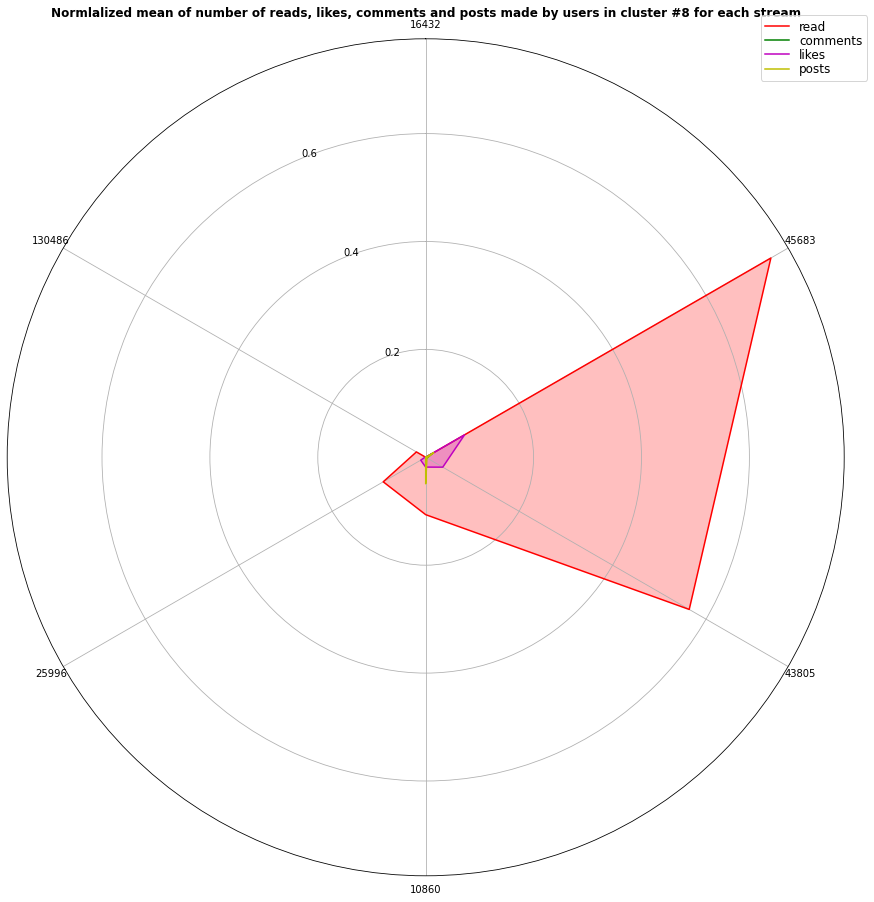

 16%|█████████▊                                                   | 8/50 [00:04<00:23,  1.78it/s]

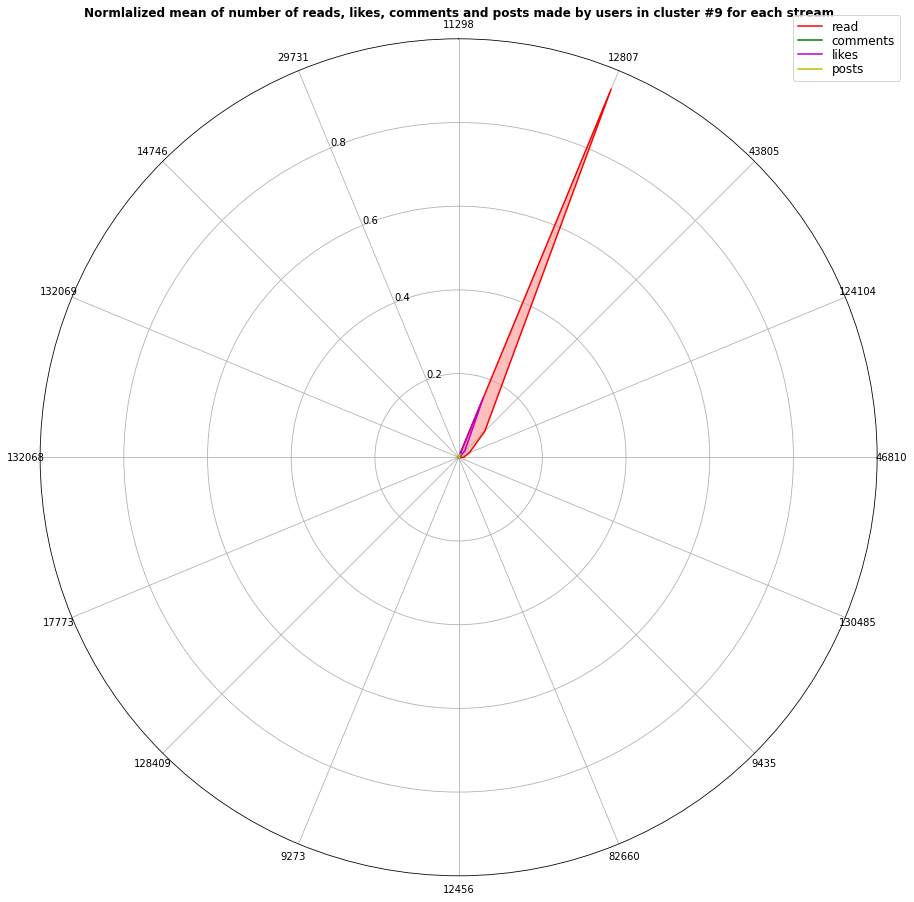

 18%|██████████▉                                                  | 9/50 [00:04<00:24,  1.68it/s]

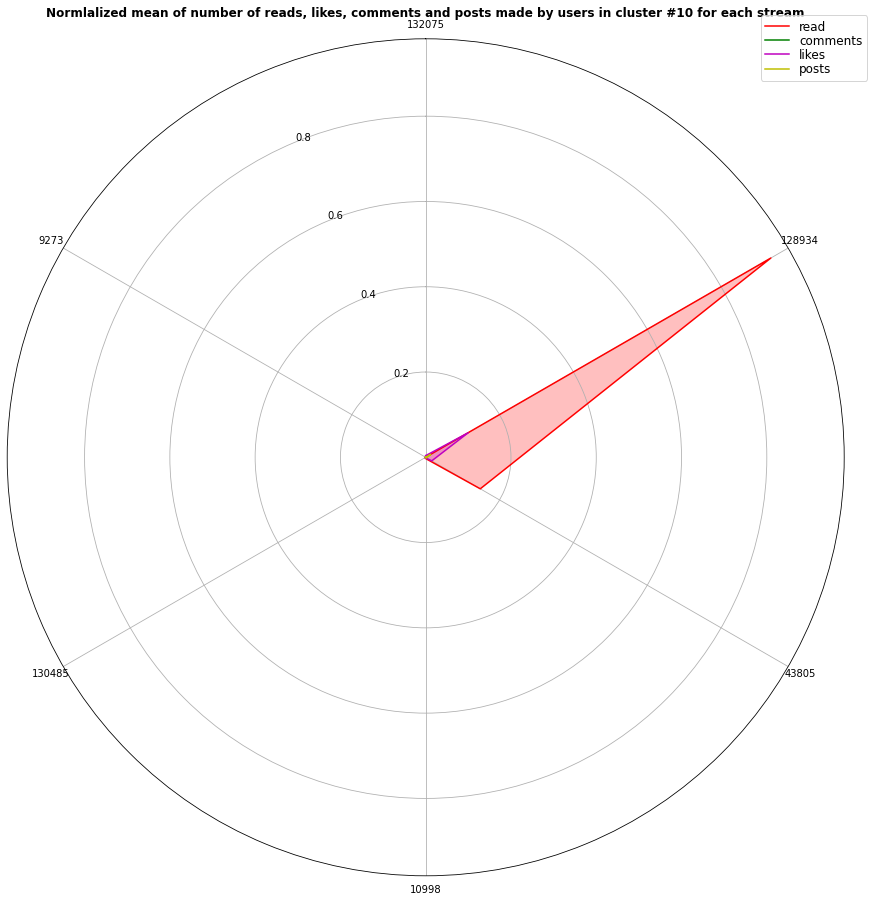

 20%|████████████                                                | 10/50 [00:05<00:22,  1.80it/s]

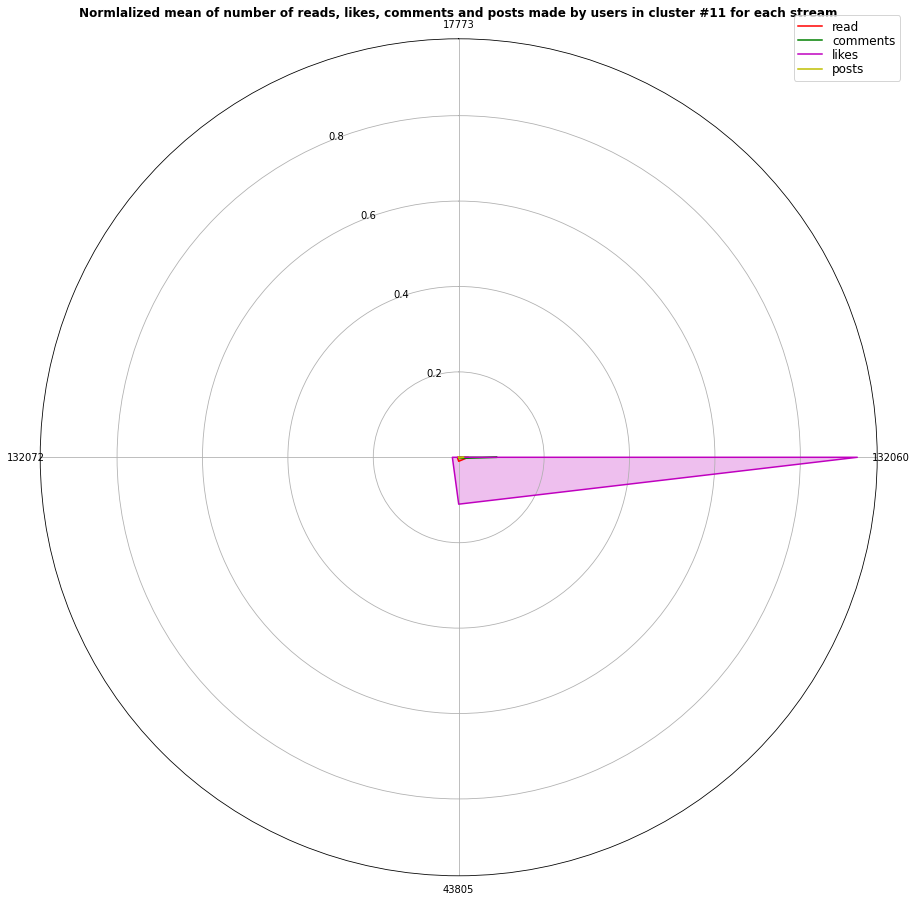

 22%|█████████████▏                                              | 11/50 [00:05<00:20,  1.92it/s]

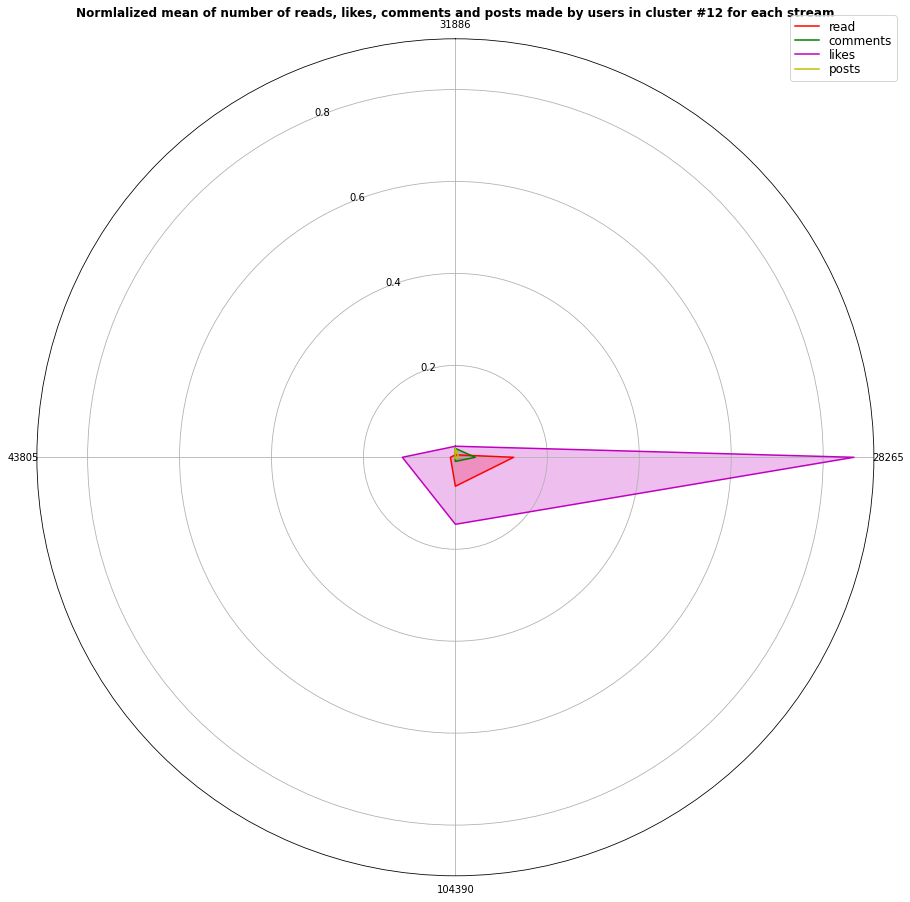

 24%|██████████████▍                                             | 12/50 [00:06<00:18,  2.01it/s]

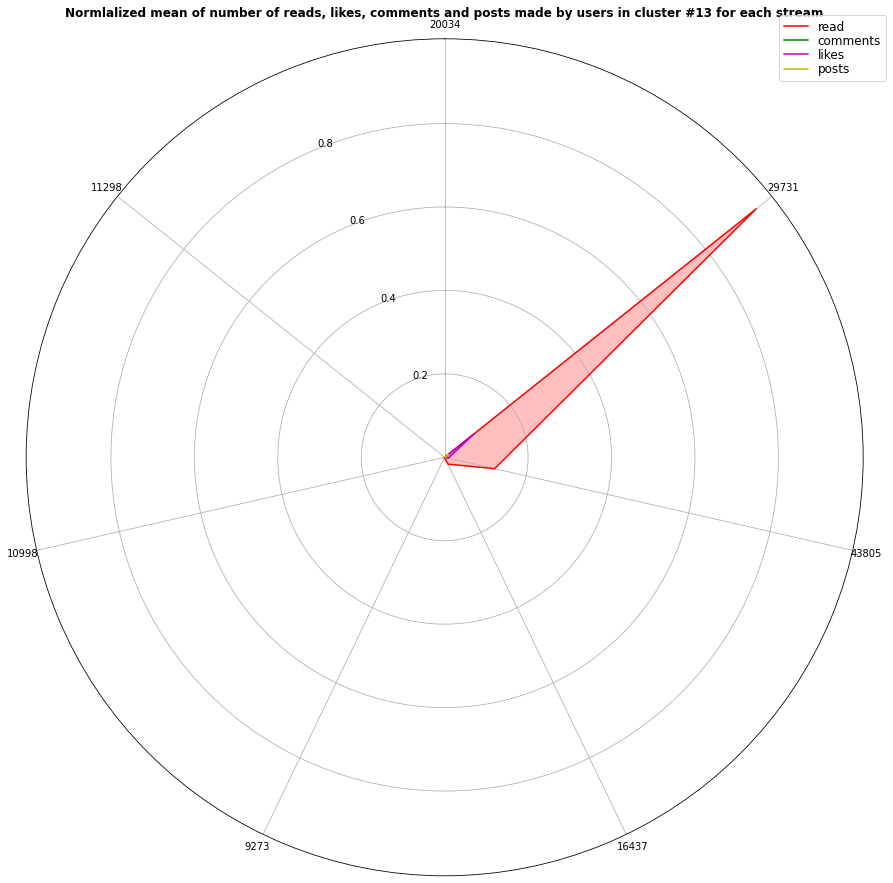

 26%|███████████████▌                                            | 13/50 [00:06<00:19,  1.92it/s]

 28%|████████████████▊                                           | 14/50 [00:07<00:17,  2.03it/s]

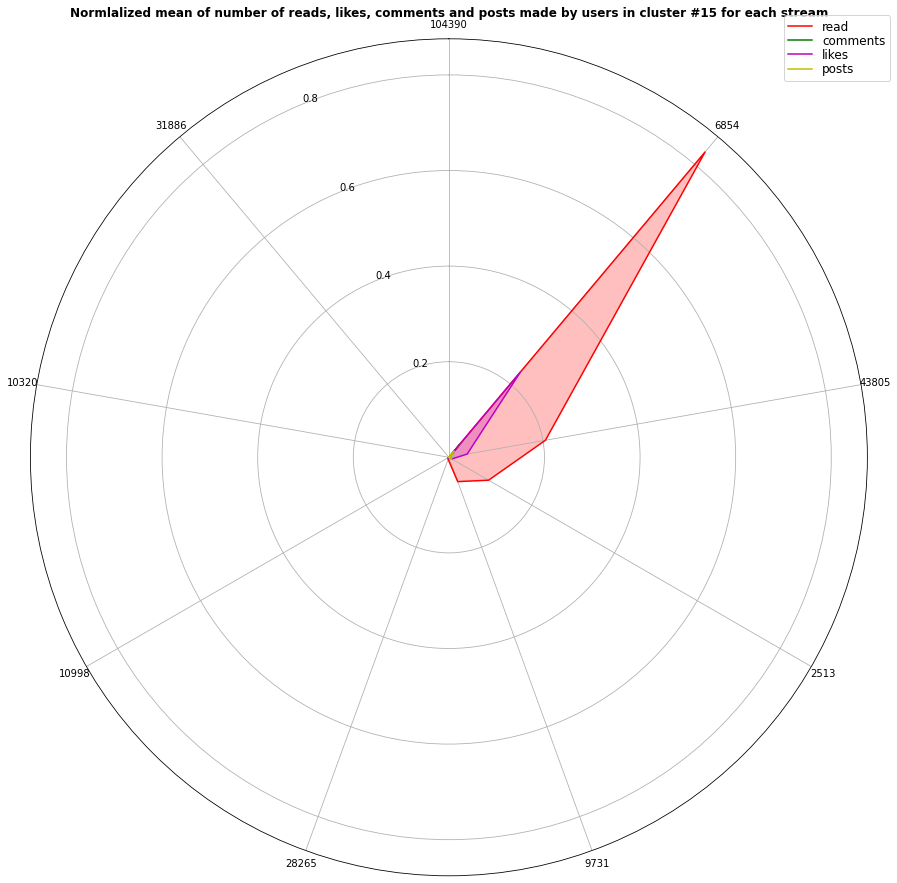

 30%|██████████████████                                          | 15/50 [00:07<00:17,  2.00it/s]

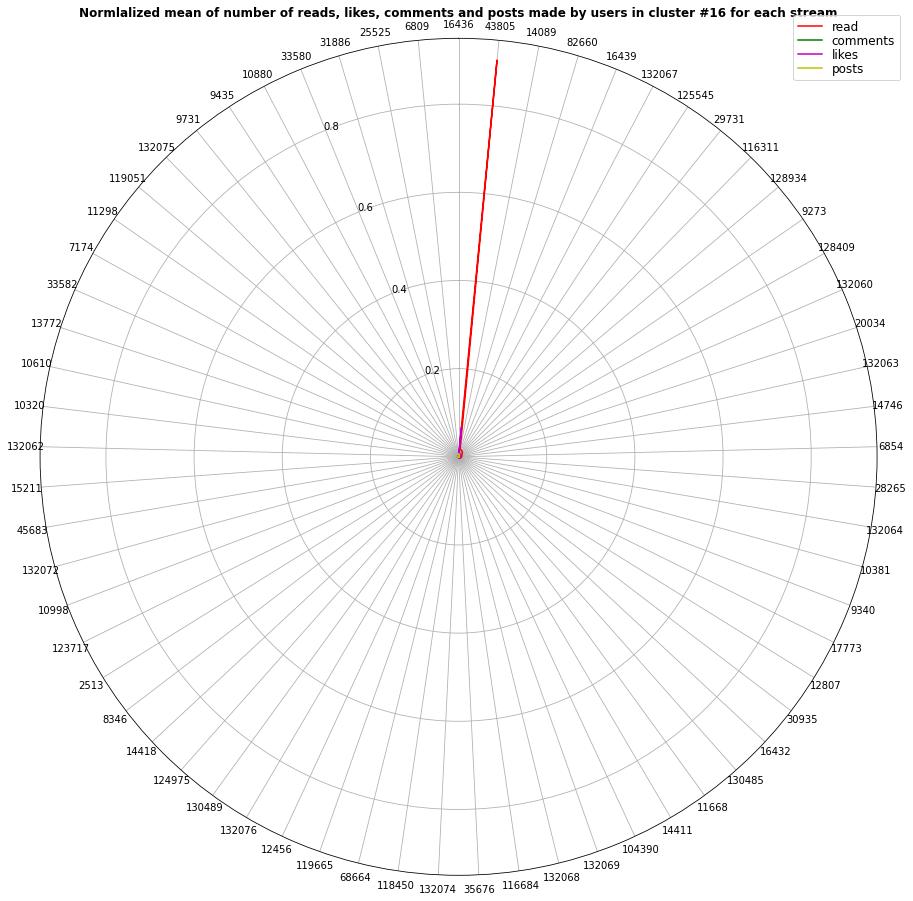

 32%|███████████████████▏                                        | 16/50 [00:11<00:54,  1.60s/it]

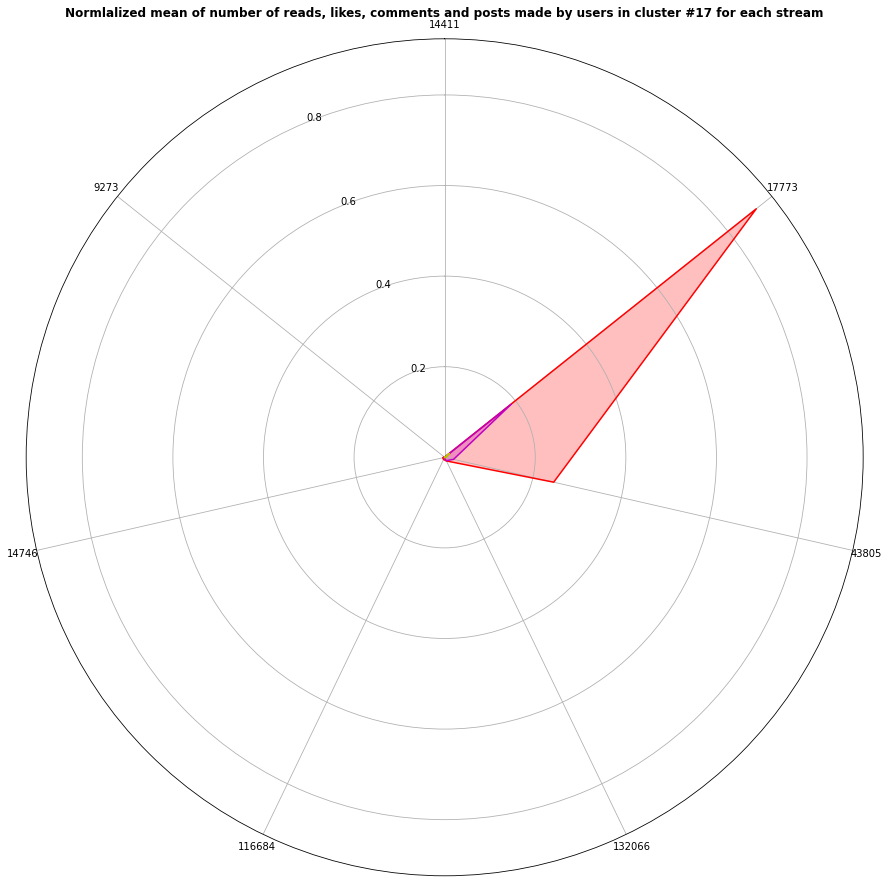

 34%|████████████████████▍                                       | 17/50 [00:12<00:41,  1.26s/it]

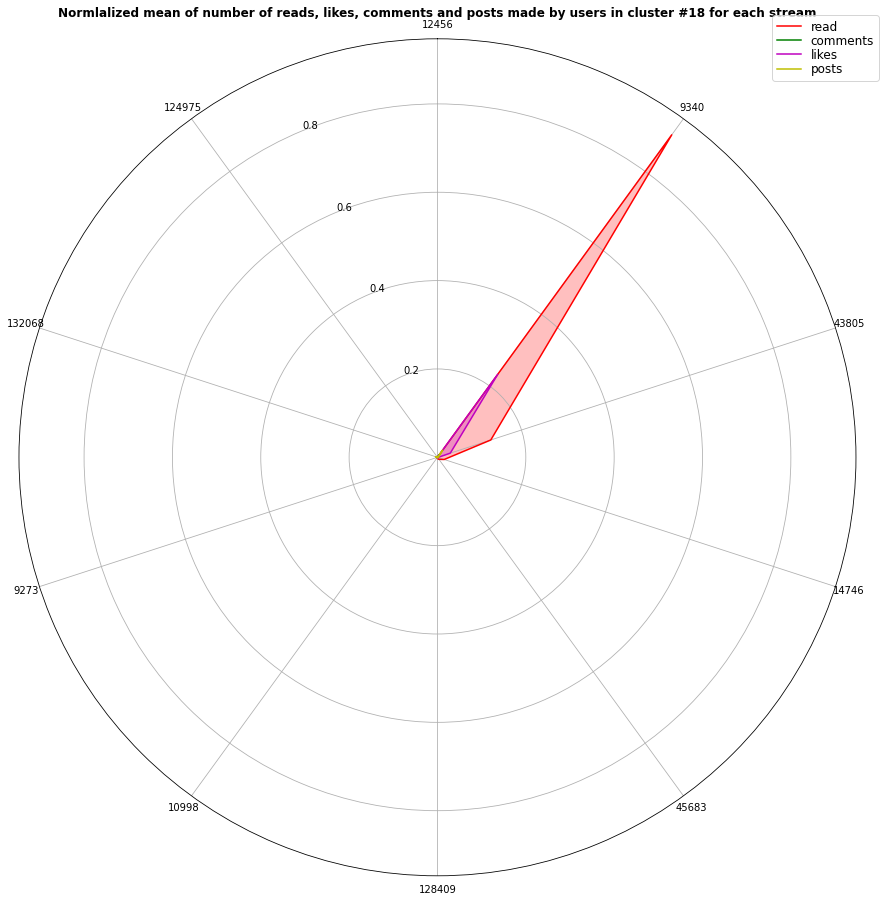

 36%|█████████████████████▌                                      | 18/50 [00:12<00:33,  1.04s/it]

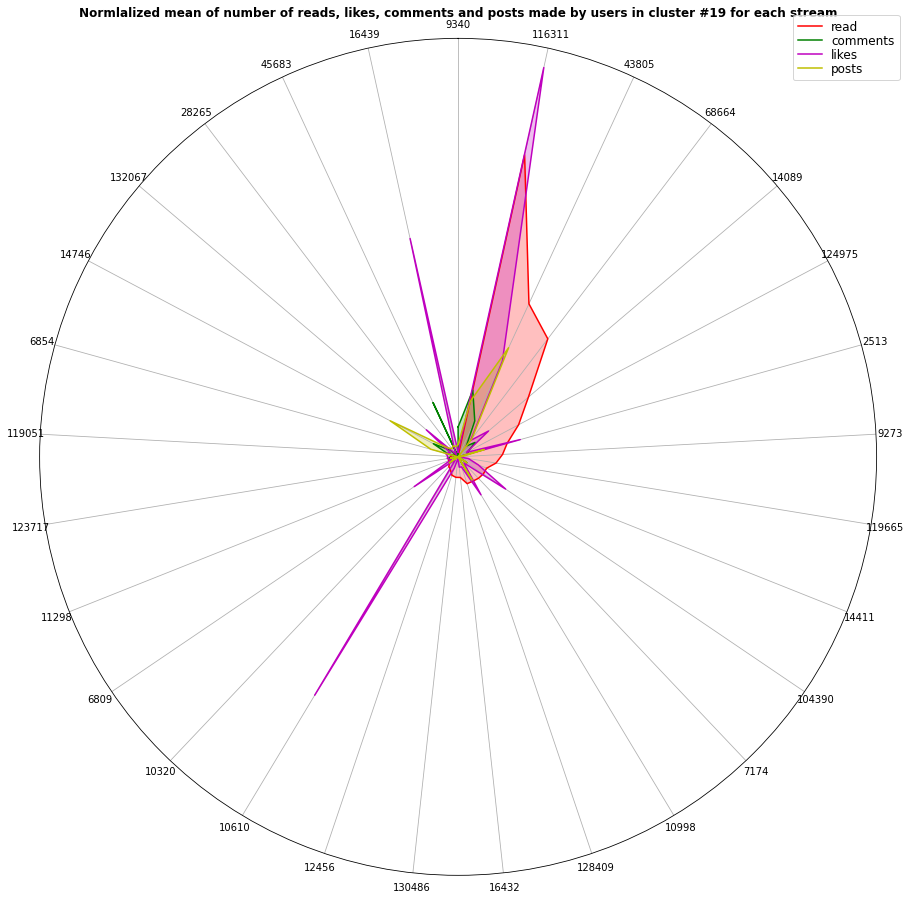

 38%|██████████████████████▊                                     | 19/50 [00:13<00:30,  1.02it/s]

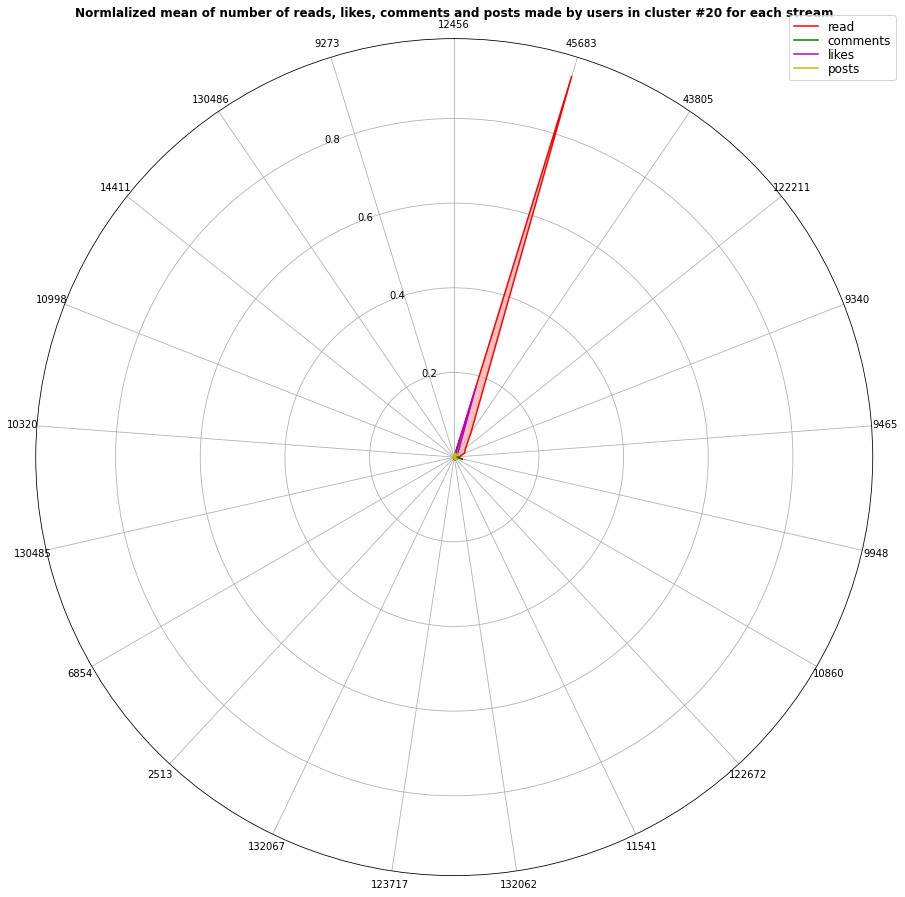

 40%|████████████████████████                                    | 20/50 [00:14<00:27,  1.10it/s]

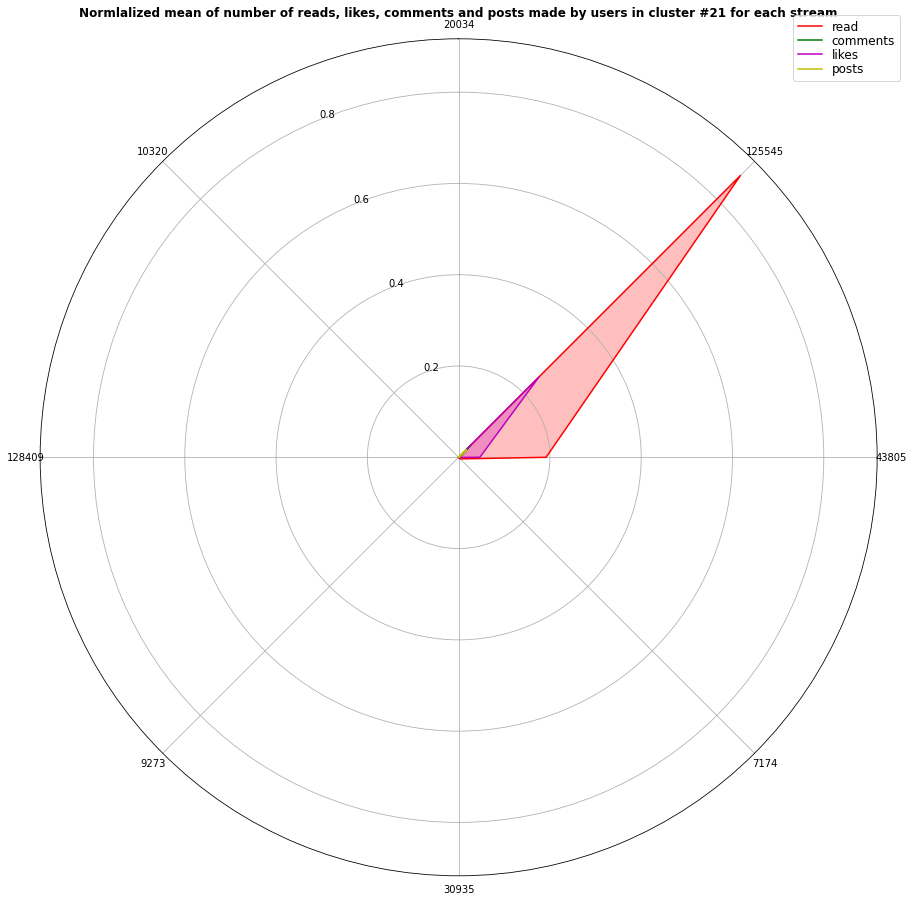

 42%|█████████████████████████▏                                  | 21/50 [00:15<00:22,  1.27it/s]

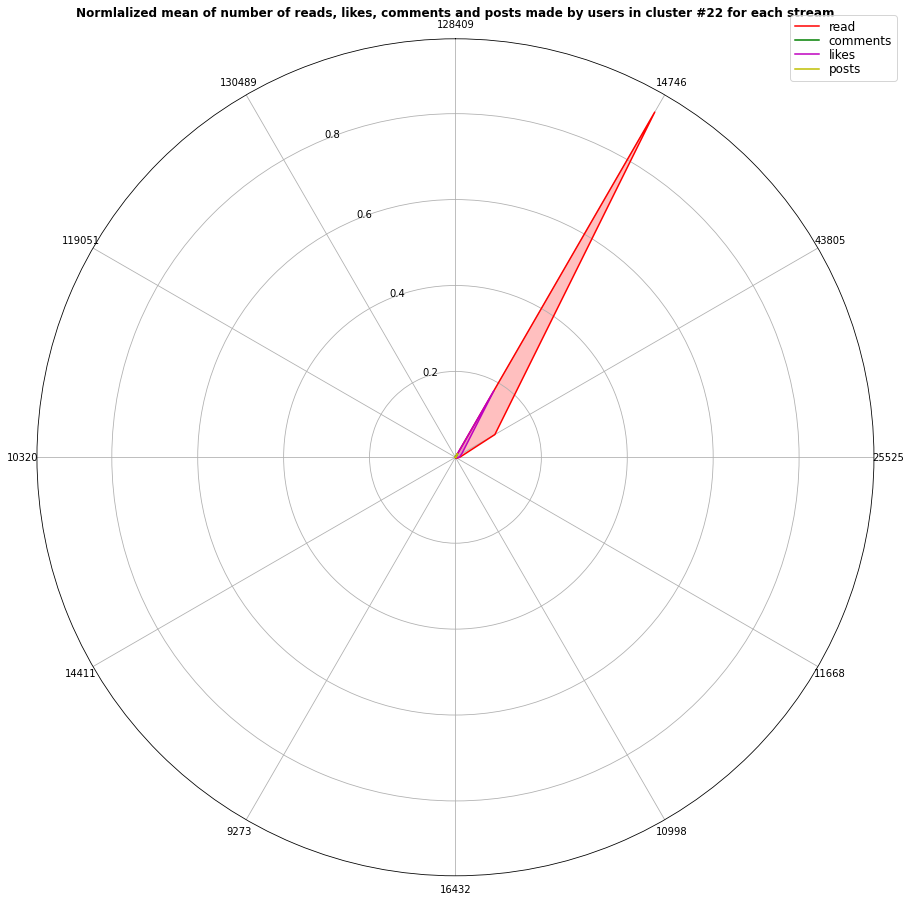

 44%|██████████████████████████▍                                 | 22/50 [00:15<00:20,  1.38it/s]

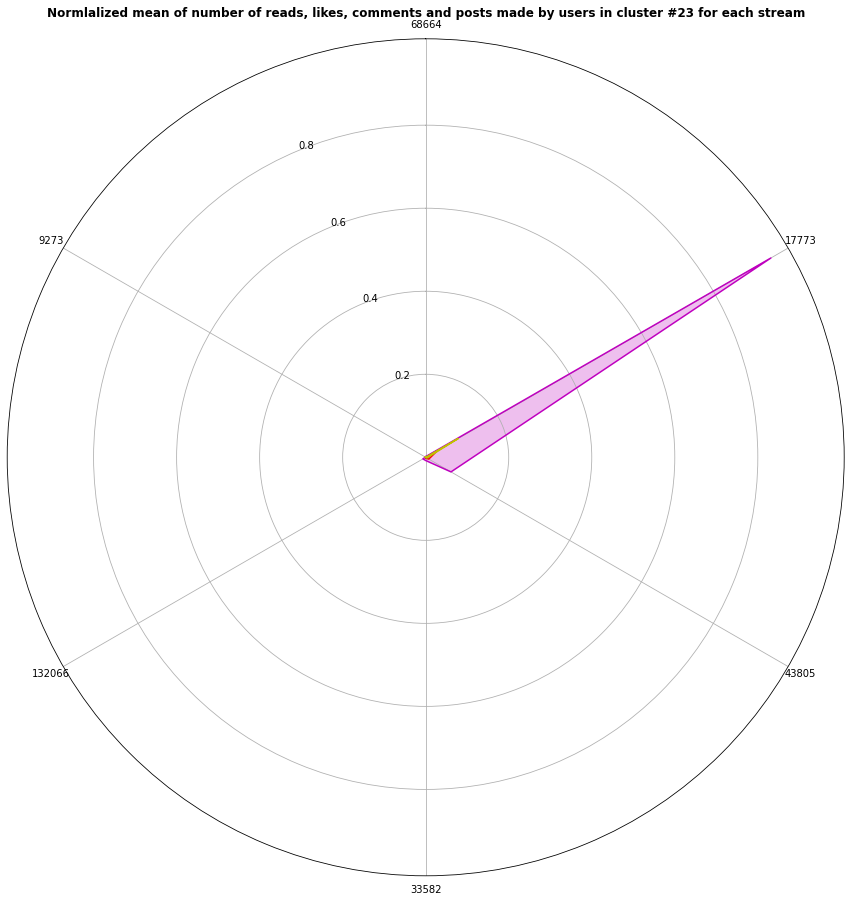

 46%|███████████████████████████▌                                | 23/50 [00:16<00:17,  1.56it/s]

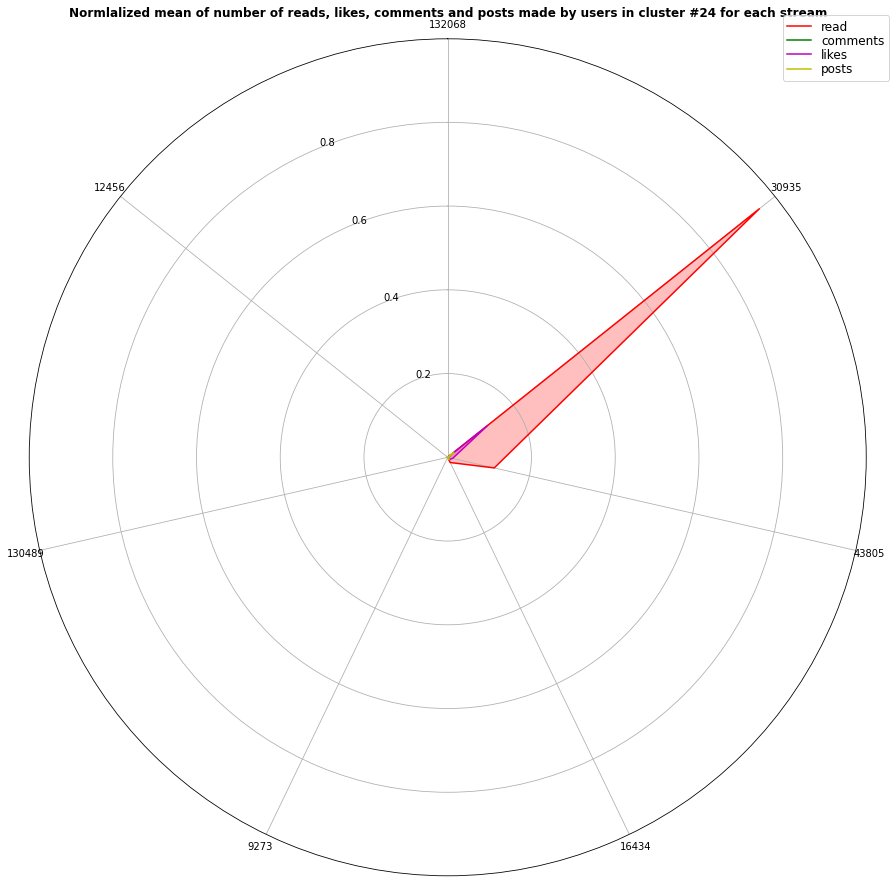

 48%|████████████████████████████▊                               | 24/50 [00:16<00:16,  1.62it/s]

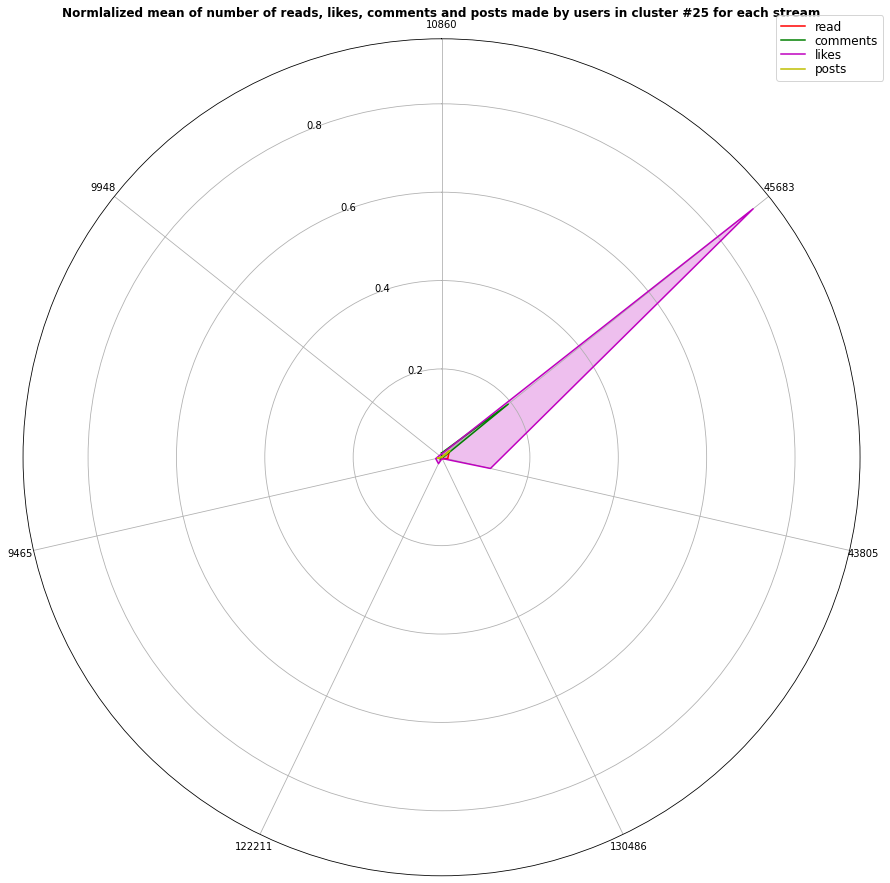

 50%|██████████████████████████████                              | 25/50 [00:17<00:14,  1.73it/s]

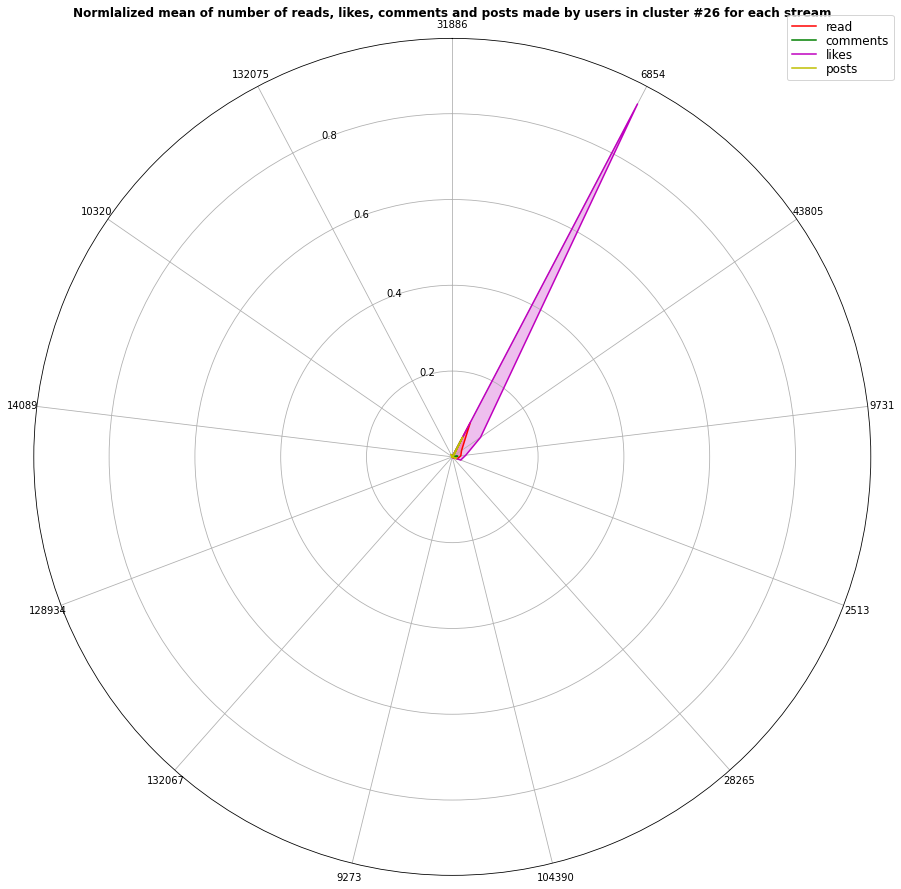

 52%|███████████████████████████████▏                            | 26/50 [00:17<00:14,  1.70it/s]

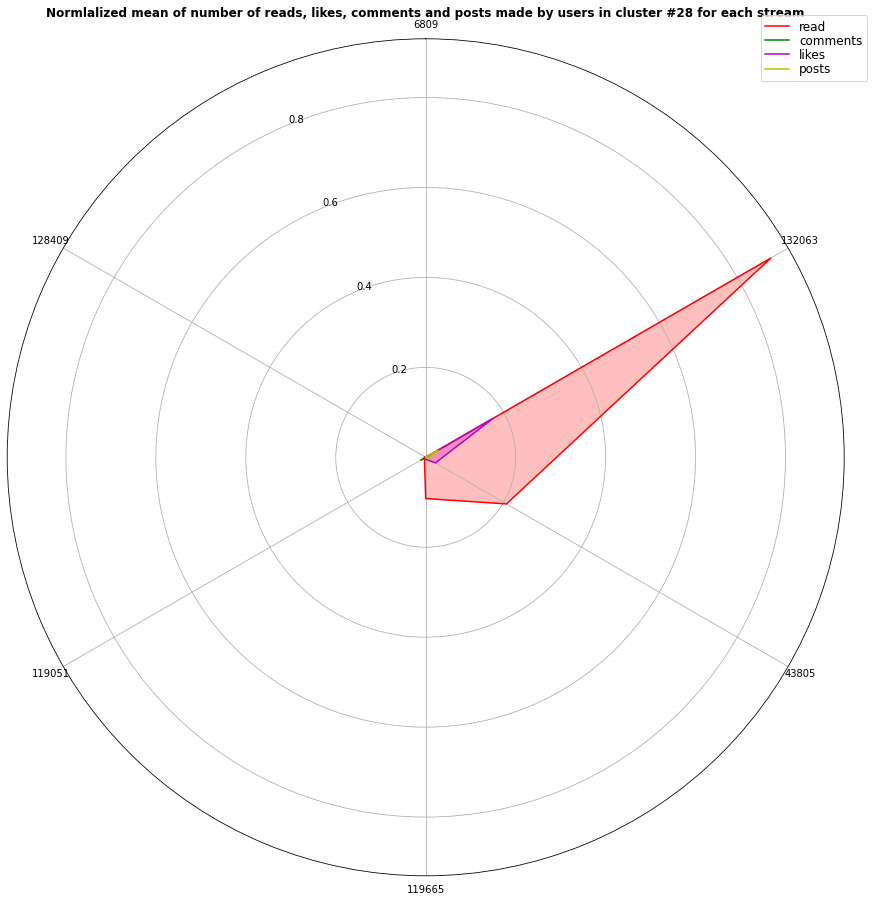

 56%|█████████████████████████████████▌                          | 28/50 [00:18<00:10,  2.05it/s]

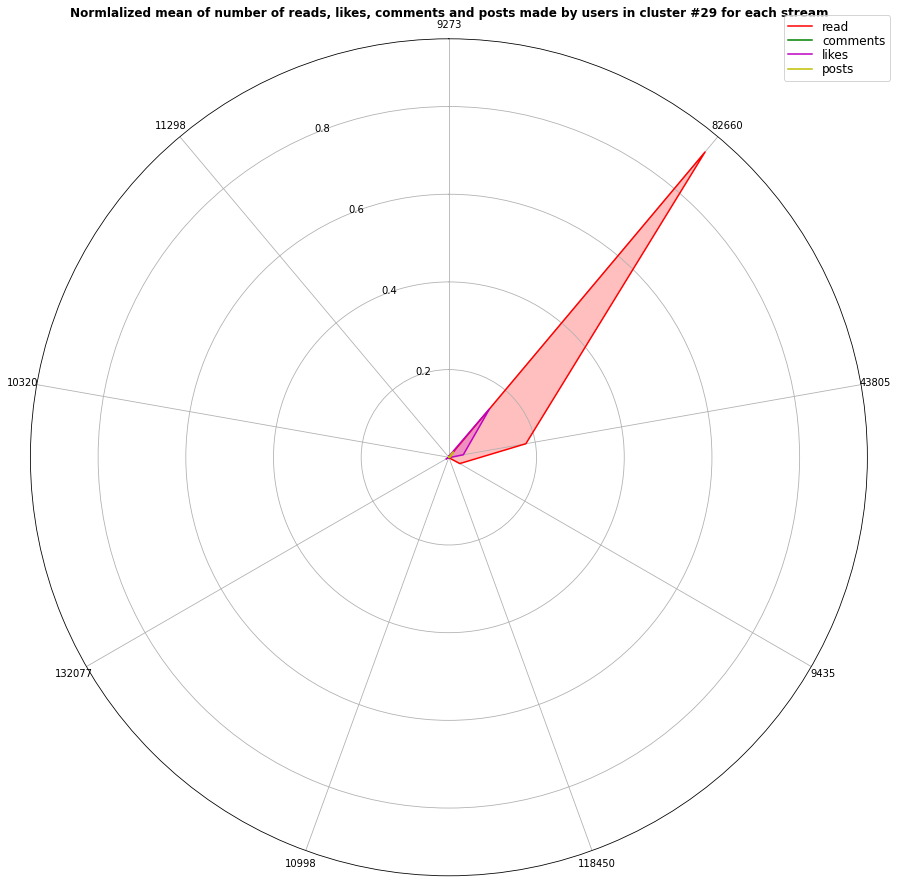

 58%|██████████████████████████████████▊                         | 29/50 [00:18<00:10,  2.00it/s]

 60%|████████████████████████████████████                        | 30/50 [00:19<00:09,  2.10it/s]

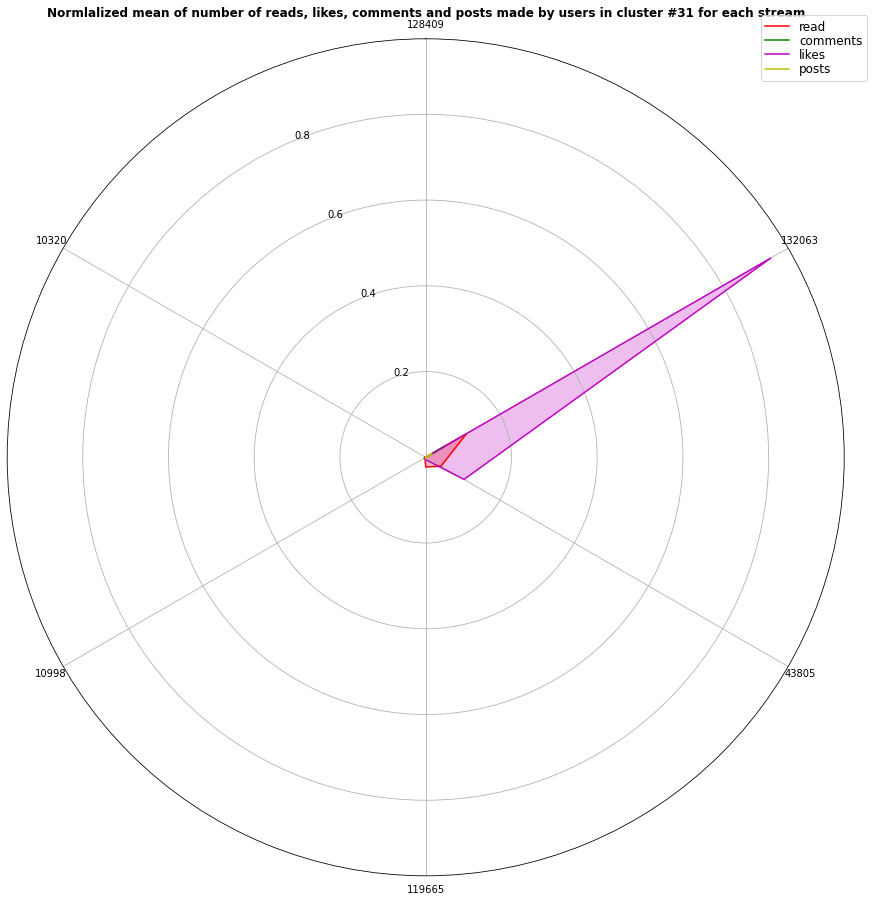

 62%|█████████████████████████████████████▏                      | 31/50 [00:19<00:09,  2.10it/s]

 64%|██████████████████████████████████████▍                     | 32/50 [00:20<00:08,  2.17it/s]

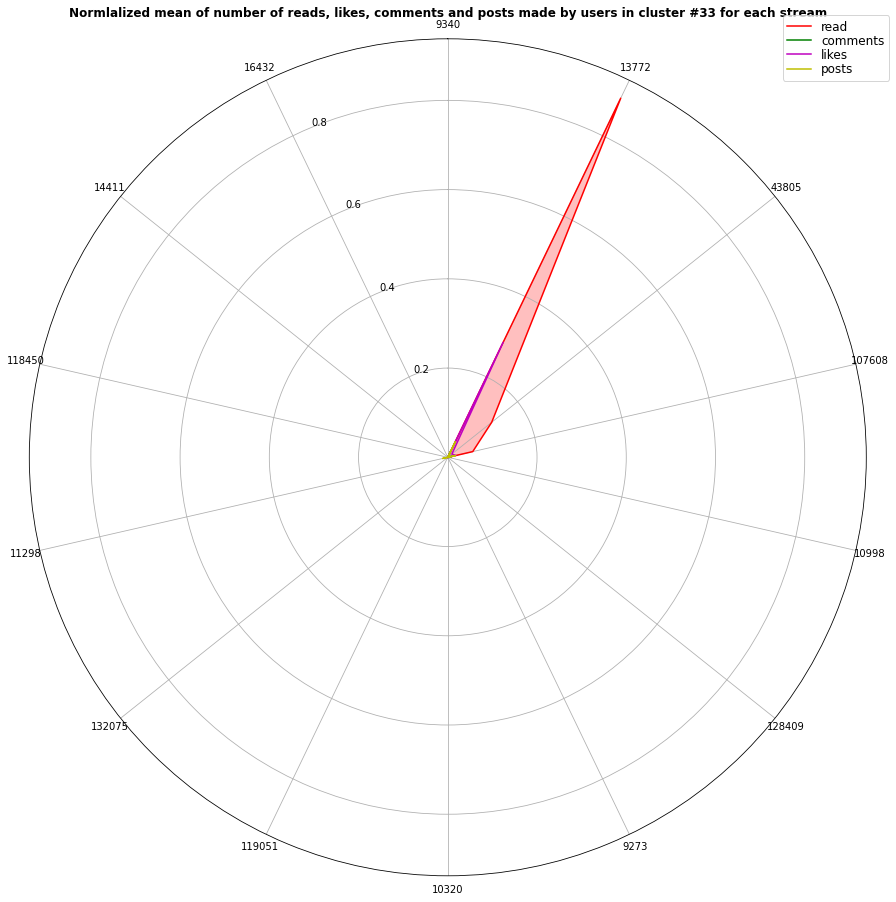

 66%|███████████████████████████████████████▌                    | 33/50 [00:20<00:08,  1.98it/s]

 68%|████████████████████████████████████████▊                   | 34/50 [00:21<00:08,  1.90it/s]

 70%|██████████████████████████████████████████                  | 35/50 [00:21<00:07,  1.98it/s]

 72%|███████████████████████████████████████████▏                | 36/50 [00:22<00:07,  1.92it/s]

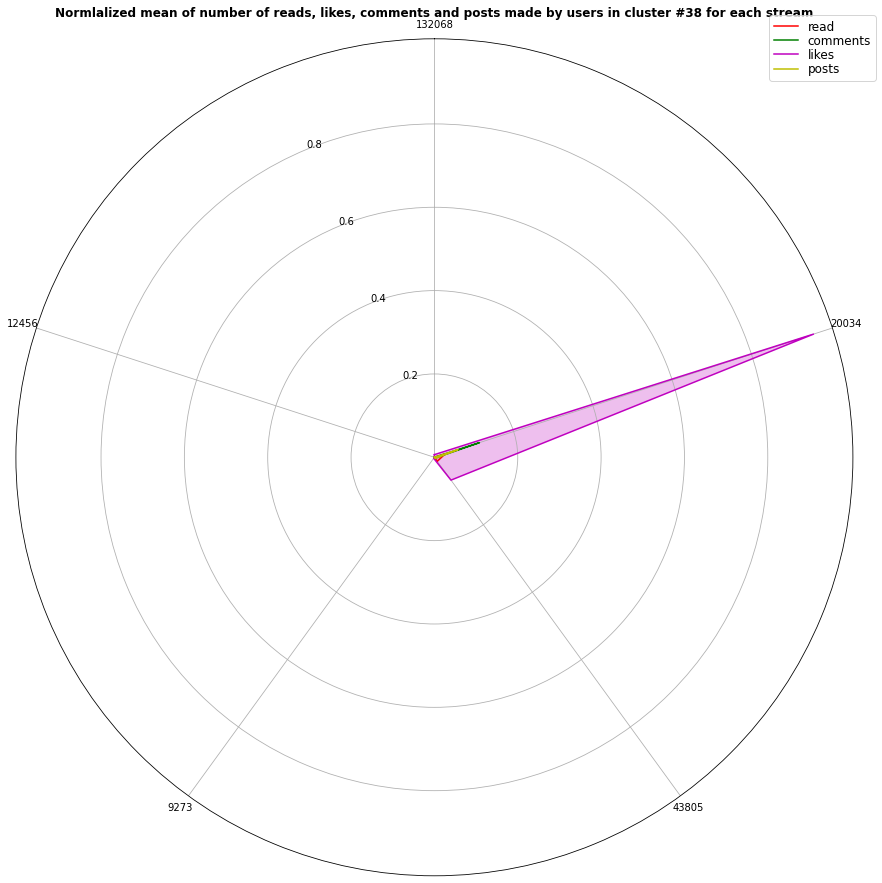

 76%|█████████████████████████████████████████████▌              | 38/50 [00:22<00:05,  2.28it/s]

 80%|████████████████████████████████████████████████            | 40/50 [00:23<00:03,  2.88it/s]

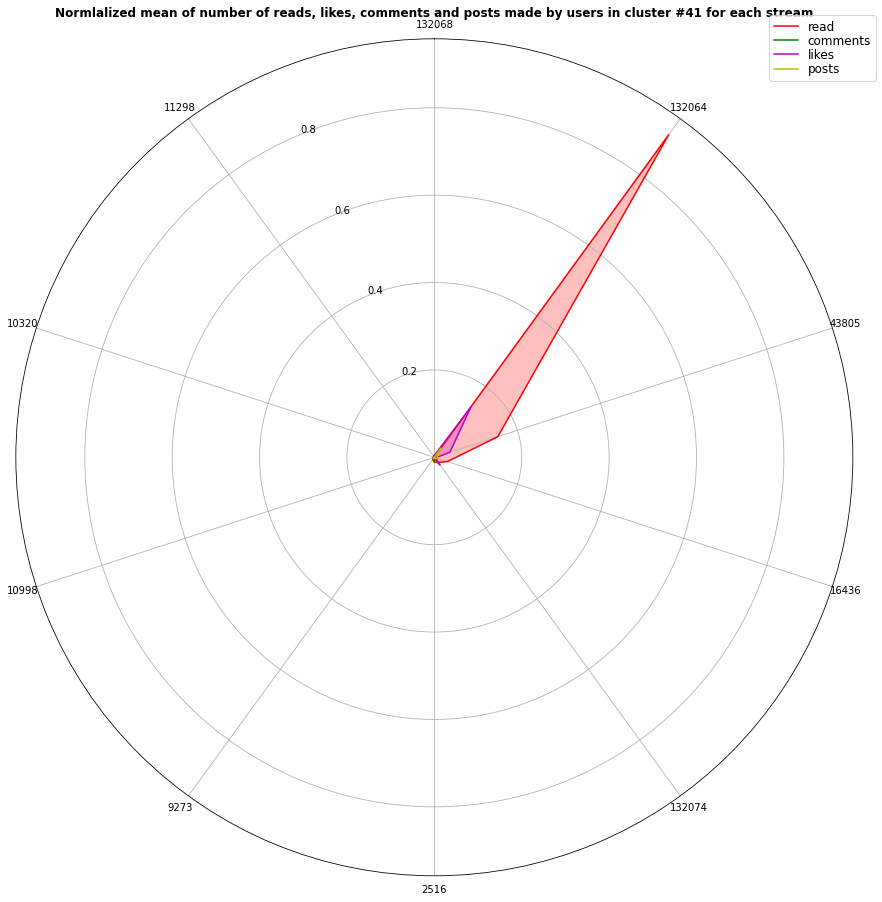

 82%|█████████████████████████████████████████████████▏          | 41/50 [00:23<00:03,  2.44it/s]

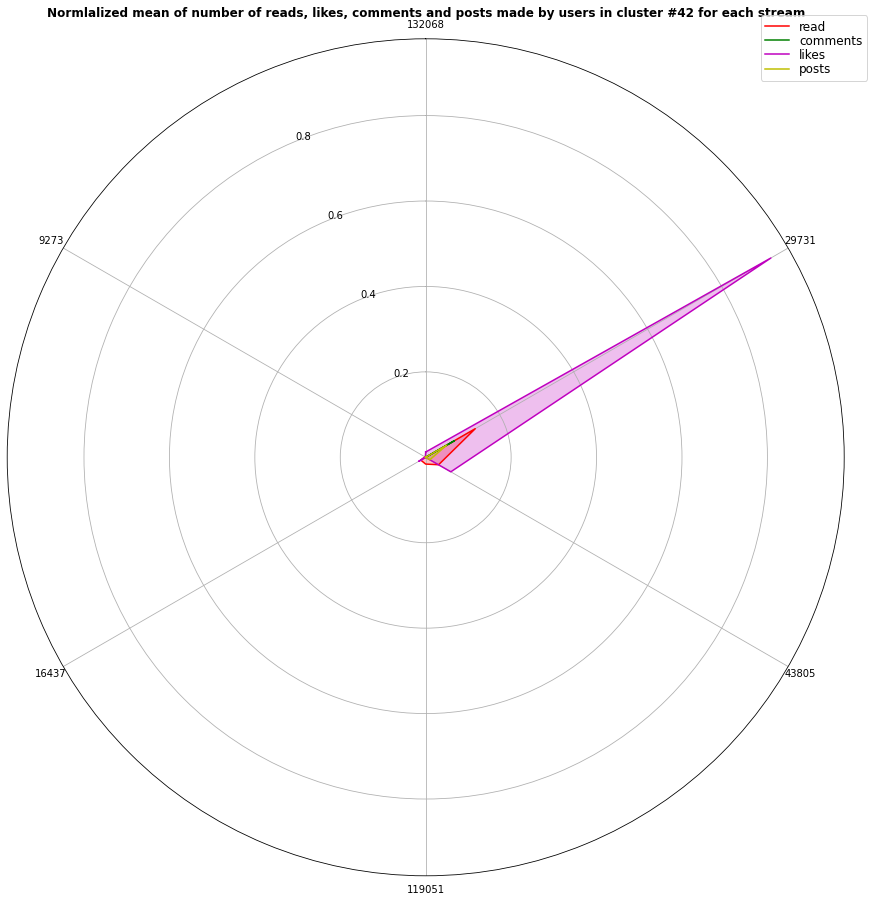

 84%|██████████████████████████████████████████████████▍         | 42/50 [00:24<00:03,  2.35it/s]

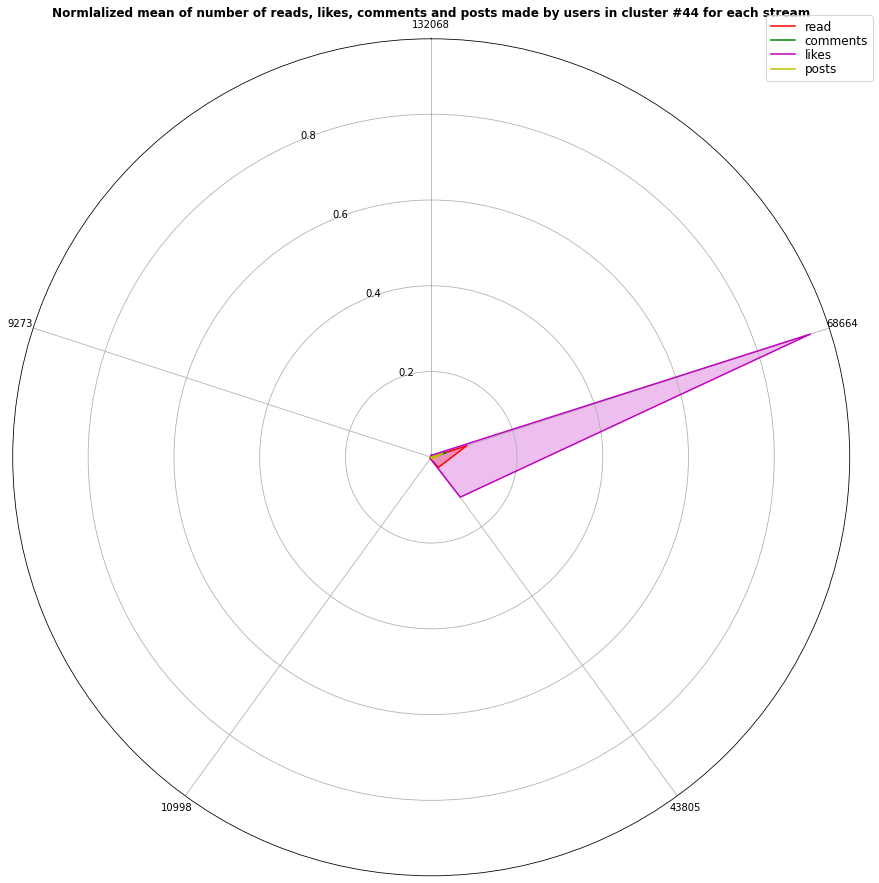

 88%|████████████████████████████████████████████████████▊       | 44/50 [00:24<00:02,  2.69it/s]

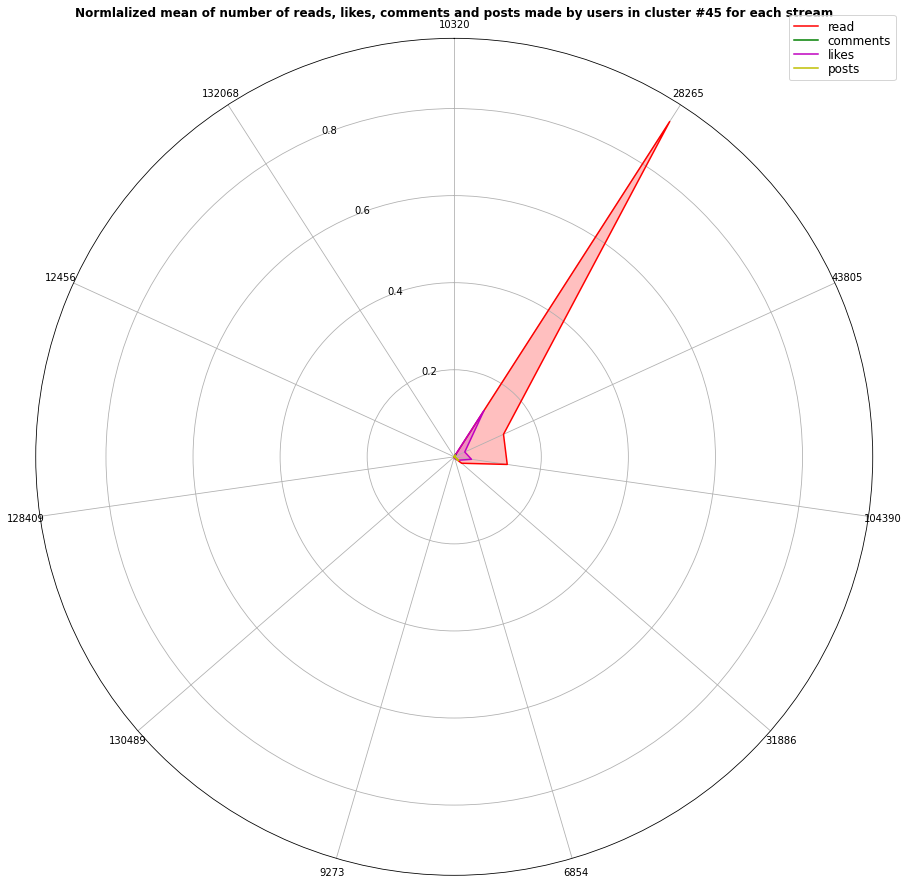

 96%|█████████████████████████████████████████████████████████▌  | 48/50 [00:25<00:00,  3.19it/s]

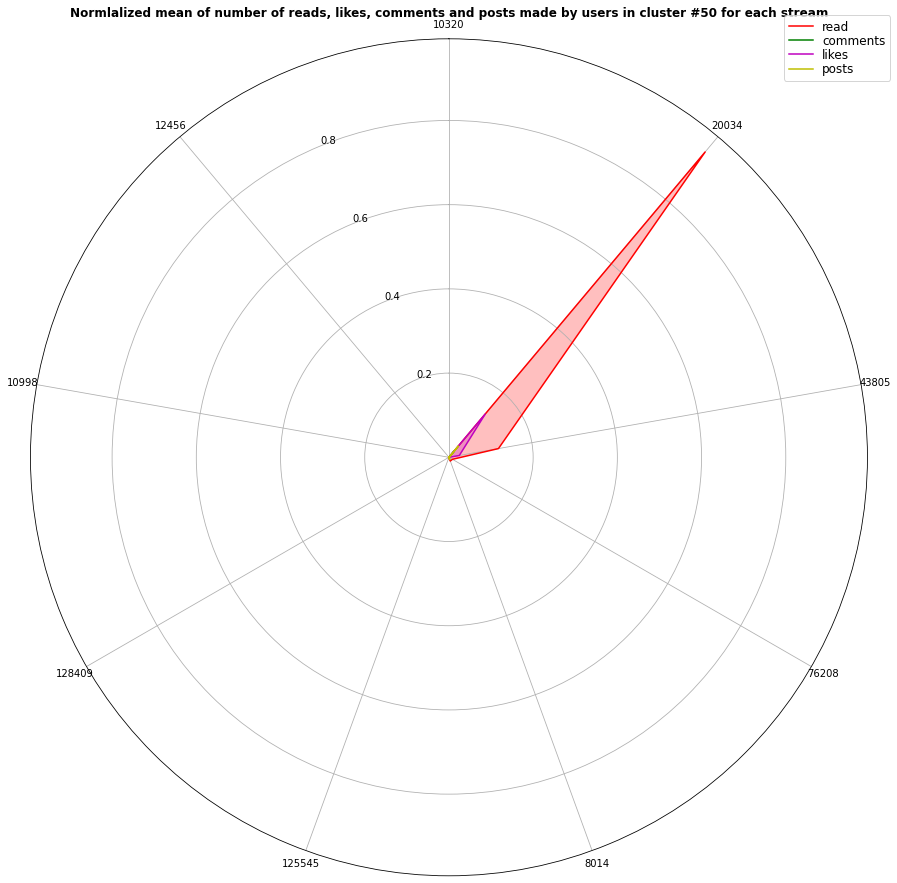

100%|████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.91it/s]

42 plotted clusters' signature
Clusters not plotted: [26, 36, 39, 42, 45, 46, 47, 48]


In [ ]:
# radar plots
xs = list(stream_names)
sort_streams_by_main_feature = True

stats_to_plot = ['mean'] # , 'std', 'min', 'max'
theta = radar_factory(len(xs))
clusters_not_plotted = []

for cluster_id in tqdm(set(cluster_labels)): # for each cluster
    
    # create plot's figures and axes
    fig, axes = plt.subplots(figsize=(15, 15), nrows=1, ncols=len(stats_to_plot), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['r', 'g', 'm', 'y']
    axes = np.array(axes) if type(axes) != 'numpy.ndarray' else axes
    for i, (ax, stat) in enumerate(zip(axes.flat, stats_to_plot)): # for each stat to plot
        
        plot_data = {'xs': xs[:], 'ys': {feature: y_values[cluster_id][feature][stat][:] for feature in features}}
        
        # rmv streams where the average reads and likes are 0
        indices_to_rmv = [i for i, (read_val, likes_val) in enumerate(zip(y_values[cluster_id]['read']['mean'], 
                                                                          y_values[cluster_id]['likes']['mean']))
                          if read_val <= 0 or likes_val <= 0]
        for i in indices_to_rmv[::-1]:
            plot_data['xs'].pop(i)
            for feature in features:
                plot_data['ys'][feature].pop(i)
                
        # sort streams by main feature values
        if sort_streams_by_main_feature:
            elems = list(zip(*sorted(zip(*[plot_data['ys'][feature] for feature in features], plot_data['xs']))))
            plot_data['xs'] = elems.pop(-1)
            plot_data['ys'] = {feature: elems[i] for i, feature in enumerate(features)}
        
        # plot
        if len(plot_data['xs']) > 2: # can't draw such a plot with less than 3 axes (streams)
            # set plot params
            ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
            ax.set_title(f'Normlalized {stat} of number of reads, likes, comments and posts made by users in cluster #{cluster_id+1} for each stream', 
                         weight='bold', size='large', position=(0.5, 1.1),  horizontalalignment='center', verticalalignment='center')

            # plot values
            theta = radar_factory(len(plot_data['xs']), frame='polygon')
            for ys, color in zip([plot_data['ys'][feature] for feature in features], colors): # for each feature
                ax.plot(theta, ys, color=color)
                ax.fill(theta, ys, facecolor=color, alpha=0.25)
            ax.set_varlabels(theta, plot_data['xs'])
            
            # plot legend
            if i == 0:
                labels = features
                legend = ax.legend(labels, loc=(0.9, .95),
                                   labelspacing=0.1, fontsize='large')
        else:
            clusters_not_plotted.append(cluster_id)
            plt.close(fig)
    plt.show()
print(f'{best_nb_clusters-len(clusters_not_plotted)} plotted clusters\' signature')
print(f'Clusters not plotted: {clusters_not_plotted}')

#### Matrices

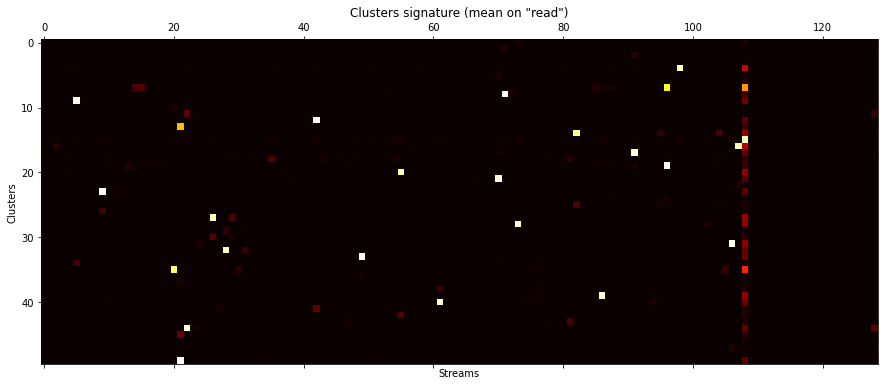

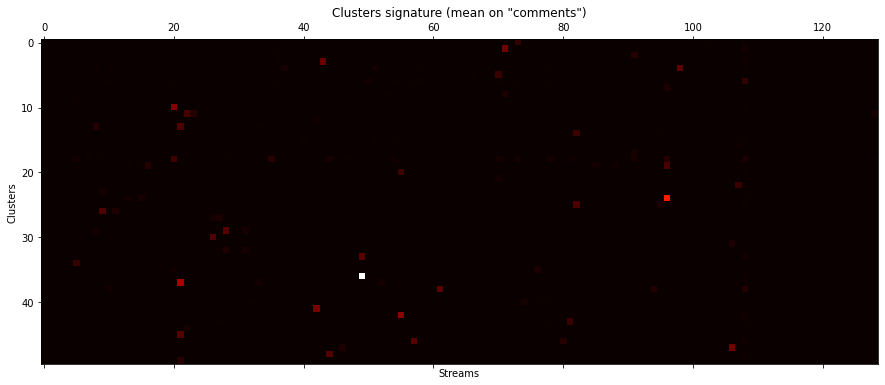

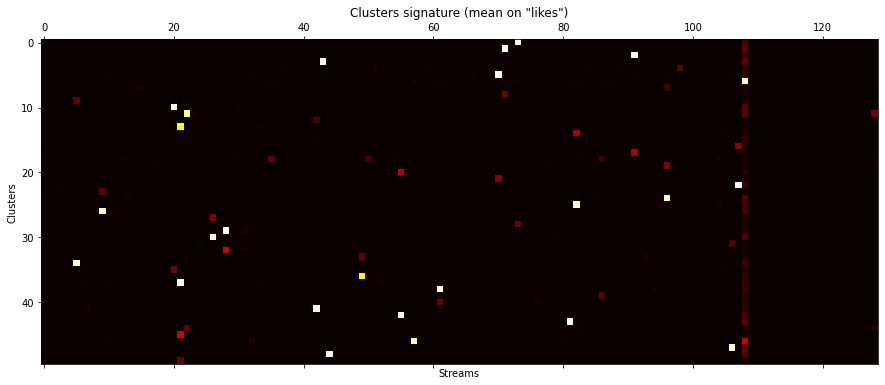

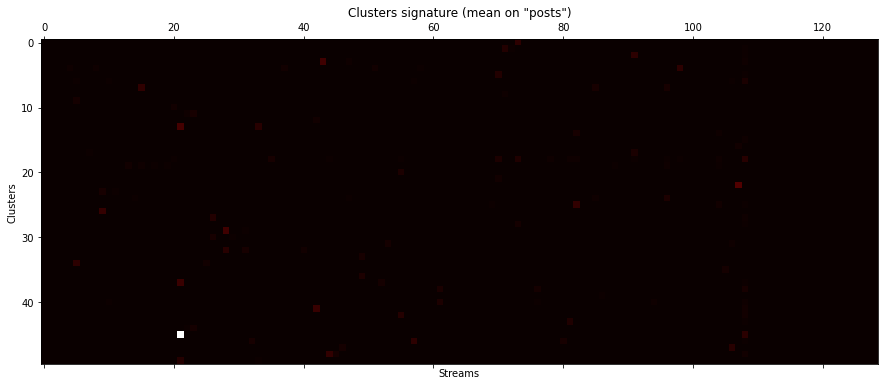

In [ ]:
# clusters' signature plots
stats_to_plot = ['mean']

for stat in stats_to_plot:
    for feature in features:
        fig, ax = plt.subplots(figsize=(15, 15))

        matrix = np.array([y_values[cluster_id][feature][stat] for cluster_id in set(cluster_labels)])
        ax.matshow(matrix, cmap=plt.cm.hot)
        
        ax.set_title(f'Clusters signature ({stat} on "{feature}")')
        ax.set_ylabel('Cluster ids')
        ax.set_xlabel('Streams')

        #for i in range(len(matrix)):
        #    for j in range(len(matrix[i])):
        #        ax.text(i, j, str(matrix[i,j]), va='center', ha='center')

#### t-SNE

In [ ]:
# run t-SNE
tsne = TSNE()
tsne_transformed = tsne.fit_transform(transformed)

In [ ]:
# plot t-SNE data visualization
x_axis = tsne_transformed[:, 0]
y_axis = tsne_transformed[:, 1]
fig_size = (10, 10)
cmap = plt.cm.gist_ncar

fig, ax = plt.subplots(figsize=fig_size)
ax.set_title('T-SNE with KMeans\' labels'if best_classifier == 0 else 'T-SNE with Spectral Clustering\'s labels')
ax.scatter(x_axis, y_axis, c=cluster_labels, cmap=cmap)

## old cells

Sources:
https://easyai.tech/en/blog/unsupervised-learning-with-python/
https://builtin.com/data-science/unsupervised-learning-python

### Hierarchical

In [ ]:
mergings = linkage(transformed, method='complete')

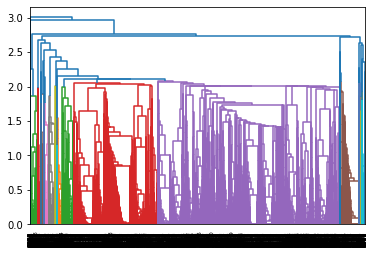

In [ ]:
dendrogram(mergings,
           leaf_rotation=90,
           leaf_font_size=6,
           )

plt.show()